In [1]:

import numpy as np
import altair as alt
from tqdm import tqdm
import sys
sys.path.append('../../')
from Scanner.general_consts import *
# alt.data_transformers.enable('csv')
import csv
import json

import os

import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
sys.path.insert(1, '/home/shouei/GreenSecurity-FirstExperiment/SplunkResearch')

from resources.section_logtypes import section_logtypes
from resources.logtypes import logtypes
from experiment_manager import ExperimentManager
log_types_str = [f"{logtype[0].lower()}_{logtype[1]}" for logtype in logtypes]
# alt.renderers.enable('altair_saver', fmts=['png'])
num_of_logtypes = 2

In [2]:

import os
import altair as alt
from toolz.curried import pipe


def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )


alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

DataTransformerRegistry.enable('json_dir')

In [10]:

# manager = ExperimentManager("../experiments/")
# # expirment_dir = "/home/shouei/GreenSecurity-FirstExperiment/SplunkResearch/experiments/exp_20230928_211413"
# # expirment_dir = "/home/shouei/GreenSecurity-FirstExperiment/SplunkResearch/experiments/exp_20230929_111545"
# # expirment_dir = "/home/shouei/GreenSecurity-FirstExperiment/SplunkResearch/experiments/exp_20231117_081610"
# # expirment_dir = "/home/shouei/GreenSecurity-FirstExperiment/SplunkResearch/experiments/exp_20240402_001050"
# expirment_dir = "/home/shouei/GreenSecurity-FirstExperiment/SplunkResearch/experiments/exp_20240407_230811"
# # expirment_dir = manager.get_last_experiment_dir()
# expirment_dir
env_name = "splunk-v4"
model_names = ["ppo", "a2c"]
reward_parameters = ["0.1667_0.1667_0.667"]
num_of_steps = 60
charts = []
for model_name in model_names:
    for reward_parameter in reward_parameters:
        experiment_dir = f"/home/shouei/GreenSecurity-FirstExperiment/SplunkResearch/experiments__/{env_name}"
        with open(f'{experiment_dir}/{model_name}_{reward_parameter}/train/reward_values_dict.json') as f:
            train_values = json.load(f)
        energy_df_model_train = pd.DataFrame(train_values['energy'], columns=['energy'])
        energy_df_model_train = energy_df_model_train[energy_df_model_train['energy'] != 0].reset_index()
        energy_df_model_train.rename(columns={'index': 'episode'}, inplace=True)
        with open(f'{experiment_dir}/{model_name}_{reward_parameter}/train/reward_dict.json') as f:
            train_values_reward = json.load(f)
        train_values.keys()
        # sum each 28 rewards to get the total reward per episode
        rewards_df = pd.DataFrame(train_values_reward['total'], columns=['rewards'])
        rewards_df = rewards_df.reset_index()
        rewards_df.rename(columns={'index': 'step'}, inplace=True)
        # an episode is x steps
        rewards_df['episode'] = rewards_df['step'] // num_of_steps
        rewards_df['step'] = rewards_df['step'] % num_of_steps
        rewards_df = rewards_df.groupby(['episode']).sum().reset_index()
        rewards_df['episode'] = rewards_df['episode'] + 1
        # rewards_total_df = rewards_total_df[rewards_total_df['total_reward'] < 100]
        chart = alt.Chart(rewards_df).mark_line().encode(
            x='episode',
            y='rewards',
            
        ).properties(
            title=' Total Reward',
            width=800,
        )
        charts.append(chart)
        
        rewards_df['mean_rewards'] = rewards_df['rewards'].rolling(window=num_of_steps).mean()
        chart = alt.Chart(rewards_df).mark_line().encode(
            x='episode',
            y='mean_rewards',
            
        ).properties(
            title=' Mean Reward',
            width=800,
        ) 
        charts.append(chart)
        rewards_distributions_df = pd.DataFrame(train_values['distributions'], columns=['distribution']).reset_index()
        rewards_distributions_df.rename(columns={'index': 'step'}, inplace=True)
        # rewards_distributions_df['episode'] = rewards_distributions_df['step'] // num_of_logtypes
        # rewards_distributions_df = rewards_distributions_df.groupby('episode').sum().reset_index()
        # rewards_distributions_df['episode'] = rewards_distributions_df['episode'] + 1

        chart = alt.Chart(rewards_distributions_df.rolling(window=num_of_steps).mean()).mark_line().encode(
            x='step',
            y='distribution',
            
        ).properties(
            title='Distributions Values',
            width=800,
        )  
        charts.append(chart)
        values_df = pd.DataFrame(train_values.values()).T
        values_df.columns = train_values.keys()
        values_df.reset_index(inplace=True)
        
        # Filter the DataFrame
        filtered_df = values_df[['index', 'duration']].dropna()


        # Create the duration line chart
        duration_chart = alt.Chart(filtered_df).mark_line(color='blue').encode(
            x='index',
            y=alt.Y('duration:Q', axis=alt.Axis(title='Duration')),
            opacity=alt.value(0.5)
        ).properties(
            title='Duration',
            width=800,
        )
        duration_chart = duration_chart.interactive()
        charts.append(duration_chart)
        # Filter the DataFrame
        filtered_df = values_df[['index', 'alerts']].dropna()
        # alert chart
        alert_chart = alt.Chart(filtered_df).mark_line(color='red').encode(
            x='index',
            y=alt.Y('alerts:Q', axis=alt.Axis(title='Alert')),
            opacity=alt.value(0.5)
        )
        alert_chart
        charts.append(alert_chart)

        
alt.vconcat(*charts)



alt.VConcatChart(...)

In [11]:
def dict_to_df(values_dict):
    energy_df = pd.DataFrame([values_dict['energy'],values_dict['duration'],values_dict['num_of_rules']]).T
    energy_df.columns = ['energy','duration','num_of_rules']
    energy_df = energy_df.reset_index()
    return energy_df

In [12]:
def dict_to_df_distribution(values_dict):
    distiribution_df = pd.DataFrame(values_dict['distributions'])
    return distiribution_df

In [13]:
def dict_to_df_alert(values_dict):
    alert_df = pd.DataFrame(values_dict['alerts'])
    return alert_df

In [14]:
dfs = []
distribution_dfs = []
alerts_dfs = []
for model_name in model_names:
    for reward_parameter in reward_parameters:
        experiment_dir = f"/home/shouei/GreenSecurity-FirstExperiment/SplunkResearch/experiments__/{env_name}"
        test = json.load(open(f'{experiment_dir}/{model_name}_{reward_parameter}/test/reward_values_dict.json'))
        test_energy_df = dict_to_df(test)
        test_energy_df['method'] = f'{model_name}_{reward_parameter}'
        dfs.append(test_energy_df)
        test_distribution = dict_to_df_distribution(test)
        test_distribution.rename(columns={0: f'{model_name}_{reward_parameter}'}, inplace=True)
        alert_df = dict_to_df_alert(test)
        alert_df.rename(columns={0: f'{model_name}_{reward_parameter}'}, inplace=True)
        alerts_dfs.append(alert_df)
        distribution_dfs.append(test_distribution)
passive_test = json.load(open(f'{experiment_dir}/no_agent/reward_values_dict.json'))
passive_test_energy_df = dict_to_df(passive_test)
passive_test_energy_df['method'] = 'test_no_agent'
dfs.append(passive_test_energy_df)
passive_distribution_df = dict_to_df_distribution(passive_test)
passive_distribution_df.rename(columns={0: 'no_agent'}, inplace=True)
distribution_dfs.append(passive_distribution_df)
passive_alert_df = dict_to_df_alert(passive_test)
passive_alert_df.rename(columns={0: 'no_agent'}, inplace=True)
alerts_dfs.append(passive_alert_df)
test_random_agent = json.load(open(f'{experiment_dir}/baseline_random/reward_values_dict.json'))
test_random_agent_energy = dict_to_df(test_random_agent)
test_random_agent_energy['method'] = 'test_random_agent'
dfs.append(test_random_agent_energy)
random_distribution = dict_to_df_distribution(test_random_agent)
random_distribution.rename(columns={0: 'random_agent'}, inplace=True)
distribution_dfs.append(random_distribution)
random_alert_df = dict_to_df_alert(test_random_agent)
random_alert_df.rename(columns={0: 'random_agent'}, inplace=True)
alerts_dfs.append(random_alert_df)

test_autopic_agent = json.load(open(f'{experiment_dir}/baseline_autopic/reward_values_dict.json'))
test_autopic_agent_energy = dict_to_df(test_autopic_agent)
test_autopic_agent_energy['method'] = 'test_autopic_agent'
dfs.append(test_autopic_agent_energy)
autopic_distribution = dict_to_df_distribution(test_autopic_agent)
autopic_distribution.rename(columns={0: 'autopic_agent'}, inplace=True)
distribution_dfs.append(autopic_distribution)
autopic_alert_df = dict_to_df_alert(test_autopic_agent)
autopic_alert_df.rename(columns={0: 'autopic_agent'}, inplace=True)
alerts_dfs.append(autopic_alert_df)

energy_df = pd.concat(dfs).reset_index()#.drop(energy_df[energy_df['episode']==0].index)
energy_df.rename(columns={'level_0': 'episode'}, inplace=True)
distribution_df = pd.concat(distribution_dfs, axis=1).reset_index()
distribution_df.rename(columns={'index': 'step'}, inplace=True)
alert_df = pd.concat(alerts_dfs, axis=1).reset_index()
alert_df.rename(columns={'index': 'step'}, inplace=True)
alert_df = alert_df.melt(value_name='alerts', var_name='method', id_vars='step')
distribution_df = distribution_df.melt(value_name='distribution', var_name='method', id_vars='step')
energy_df
        

,episode,index,energy,duration,num_of_rules,method
0,0,0,NaN,20.501163,NaN,ppo_0.1667_0.1667_0.667
1,1,1,NaN,12.306734,NaN,ppo_0.1667_0.1667_0.667
2,2,2,NaN,12.174780,NaN,ppo_0.1667_0.1667_0.667
3,3,3,NaN,13.366706,NaN,ppo_0.1667_0.1667_0.667
4,4,4,NaN,14.422858,NaN,ppo_0.1667_0.1667_0.667
...,...,...,...,...,...,...
145,25,25,NaN,13.023404,NaN,test_autopic_agent
146,26,26,NaN,11.824435,NaN,test_autopic_agent
147,27,27,NaN,12.694971,NaN,test_autopic_agent
148,28,28,NaN,13.175402,NaN,test_autopic_agent


In [15]:
alt.Chart(alert_df).mark_bar().encode(
    x='method',
    y='mean(alerts)',
    color='method',
).properties(
    title='Alerts',
)

alt.Chart(...)

In [16]:
# max_actions_value = 20000
# baseline_dfs_list = []
# action_values = [0, max_actions_value, max_actions_value//2]
# for search_window in [5, 15, 30, 60]:
#         for max_actions_value in [0,1000, 20000, 50000, 200000]:#, 100000, 200000]:
#             i = f"{search_window}_{max_actions_value}"
#             with open(f'{expirment_dir}/test_baseline_{i}/reward_values_dict.json') as f:
#                 baseline_values = json.load(f)
#             energy_df_baseline = dict_to_df(baseline_values)
#             energy_df_baseline['method'] = f'baseline_{i}'
#             baseline_dfs_list.append(energy_df_baseline)
# energy_df = pd.concat(baseline_dfs_list).reset_index()
# energy_df.rename(columns={'level_0': 'episode'}, inplace=True)

        



In [17]:
# energy_df = energy_df[energy_df['method'] == 'baseline02'].reset_index()
# for i in range(18):
#     if i < 6:
#         j = 0
#     elif i < 12:
#         j = 1
#     else:
#         j = 2
#     energy_df.loc[i, 'method'] = f'baseline0{j}'
# energy_df

In [18]:
num_of_rules = 5

In [19]:
# energy_df[energy_df['num_of_rules']!=num_of_rules]['episode'].unique()

In [20]:
# energy_df.drop(energy_df[energy_df['episode'].isin(energy_df[energy_df['num_of_rules']!=num_of_rules]['episode'].unique())].index, inplace=True)
# energy_df

In [21]:
distribution_df.groupby('method').describe()['distribution']

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
a2c_0.1667_0.1667_0.667,1799.0,4.373998e-02,0.033804,1.944602e-03,1.409816e-02,1.774962e-02,8.313740e-02,1.257869e-01
autopic_agent,1796.0,5.859838e-01,0.087356,1.756579e-01,5.356028e-01,5.842963e-01,6.500466e-01,8.003403e-01
no_agent,27.0,1.000000e-12,0.000000,1.000000e-12,1.000000e-12,1.000000e-12,1.000000e-12,1.000000e-12
ppo_0.1667_0.1667_0.667,1797.0,9.645088e-02,0.071632,4.480311e-03,3.267096e-02,3.990771e-02,1.804935e-01,2.267090e-01
random_agent,1796.0,5.079635e-01,0.081734,1.487353e-01,4.617556e-01,5.056400e-01,5.711150e-01,7.672454e-01


In [22]:

alt.Chart(distribution_df.groupby('method').describe()['distribution'].reset_index()).mark_bar().encode(
    x=alt.X('method', sort='-y'),
    y=alt.Y('mean', sort='-x'),
    color=alt.Color('method', sort='-y'),
    tooltip=['method', 'mean', 'std'],
    text=alt.Text('mean', format='.2f')
).properties(
    title='Distributions per method',

)

alt.Chart(...)

In [23]:
energy_df = energy_df.drop(index=0)

In [24]:
# make a bar chart of the mean duration with std
alt.Chart(energy_df.groupby('method').describe()['duration'].reset_index()).mark_bar().encode(
    x=alt.X('method', sort='-y'),
    y=alt.Y('mean', sort='-x'),
    color=alt.Color('method', scale=alt.Scale(scheme='category20'), sort='-y'),
    tooltip=['method', 'mean', 'std'],
    text=alt.Text('mean', format='.2f')
).properties(
    title='Duration per method',

)


alt.Chart(...)

In [25]:
# make a bar chart of the mean duration with std
alt.Chart(energy_df.groupby('method').describe()['energy'].reset_index()).mark_bar().encode(
    x=alt.X('method', sort='-y'),
    y=alt.Y('mean', sort='-x'),
    color='method',
    tooltip=['method', 'mean', 'std'],
    text=alt.Text('mean', format='.2f')
).properties(
    title='Energy per method',

)

alt.Chart(...)

In [26]:
energy_df

,episode,index,energy,duration,num_of_rules,method
1,1,1,NaN,12.306734,NaN,ppo_0.1667_0.1667_0.667
2,2,2,NaN,12.174780,NaN,ppo_0.1667_0.1667_0.667
3,3,3,NaN,13.366706,NaN,ppo_0.1667_0.1667_0.667
4,4,4,NaN,14.422858,NaN,ppo_0.1667_0.1667_0.667
5,5,5,NaN,13.078984,NaN,ppo_0.1667_0.1667_0.667
...,...,...,...,...,...,...
145,25,25,NaN,13.023404,NaN,test_autopic_agent
146,26,26,NaN,11.824435,NaN,test_autopic_agent
147,27,27,NaN,12.694971,NaN,test_autopic_agent
148,28,28,NaN,13.175402,NaN,test_autopic_agent


In [27]:
# color_map = alt.Scale(domain=['DRL', 'test_no_agent', 'test_random_agent'], range=['red', 'green', 'blue'])
alt.Chart(energy_df).mark_line(point=True).encode(
    x='episode',
    y='duration',
    color=alt.Color('method'),
    
).properties(
    title='Duration consumption of the DRL method vs the baseline methods',
    width=1200,
)

alt.Chart(...)

In [28]:
alt.Chart(energy_df).mark_line(point=True).encode(
    x='episode',
    y='energy',
    color='method'
    
).properties(
    title='Energy consumption of the DRL method vs the baseline methods',
    width=800,
)

alt.Chart(...)

In [29]:
from splunk_tools import SplunkTools
savedsearches = ["Windows Event For Service Disabled","Detect New Local Admin account", "ESCU Network Share Discovery Via Dir Command Rule", "Known Services Killed by Ransomware", "Non Chrome Process Accessing Chrome Default Dir"]
splunk_tools = SplunkTools(savedsearches)
rules_names = splunk_tools.active_saved_searches

/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host '132.72.81.150'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [30]:

def get_time_rule_energy_df(mode, file_name):
    with open(f'{experiment_dir}/{mode}/{file_name}.json') as f:
        time_rules_energy_dict_test = json.load(f)
    time_rules_energy_dict_test_data = []
    
    for e in time_rules_energy_dict_test:
        # if len(v) == 0:
        #     for n in rules_names:
        #         time_rules_energy_dict_test_data.append({'time': e['time_range'], 'rule_name': n, 'energy': 0})
        # rules_names = []
        
        for i, r in enumerate(e['rules']):
            rule_name = rules_names[i]['title']
            time_rules_energy_dict_test_data.append({'time': e['time_range'], 'rule_name': rule_name, 'duration': r, 'num_of_rules': len(e['rules']), 'method': mode})
    return pd.DataFrame(time_rules_energy_dict_test_data)
dfs = []
for model_name in model_names:
    for reward_parameter in reward_parameters:
        time_rules_energy_df = get_time_rule_energy_df(f"{model_name}_{reward_parameter}/test", 'time_rules_energy')
        dfs.append(time_rules_energy_df)       
random_baseline_time_rules_energy_df = get_time_rule_energy_df("baseline_random", 'time_rules_energy')
dfs.append(random_baseline_time_rules_energy_df)
passive_baseline_time_rules_energy_df = get_time_rule_energy_df("no_agent", 'time_rules_energy')
dfs.append(passive_baseline_time_rules_energy_df)
autopic_baseline_time_rules_energy_df = get_time_rule_energy_df("baseline_autopic", 'time_rules_energy')
dfs.append(autopic_baseline_time_rules_energy_df)
time_rules_energy_df = pd.concat(dfs).reset_index()
time_rules_energy_df


,index,time,rule_name,duration,num_of_rules,method
0,0,"('04/30/2023:08:00:00', '04/30/2023:09:00:00')",Detect New Local Admin account,4.009449,5,ppo_0.1667_0.1667_0.667/test
1,1,"('04/30/2023:08:00:00', '04/30/2023:09:00:00')",ESCU Network Share Discovery Via Dir Command Rule,5.153398,5,ppo_0.1667_0.1667_0.667/test
2,2,"('04/30/2023:08:00:00', '04/30/2023:09:00:00')",Known Services Killed by Ransomware,3.862556,5,ppo_0.1667_0.1667_0.667/test
3,3,"('04/30/2023:08:00:00', '04/30/2023:09:00:00')",Non Chrome Process Accessing Chrome Default Dir,4.266821,5,ppo_0.1667_0.1667_0.667/test
4,4,"('04/30/2023:08:00:00', '04/30/2023:09:00:00')",Windows Event For Service Disabled,3.208939,5,ppo_0.1667_0.1667_0.667/test
...,...,...,...,...,...,...
745,145,"('05/01/2023:13:00:00', '05/01/2023:14:00:00')",Detect New Local Admin account,2.579684,5,baseline_autopic
746,146,"('05/01/2023:13:00:00', '05/01/2023:14:00:00')",ESCU Network Share Discovery Via Dir Command Rule,3.209470,5,baseline_autopic
747,147,"('05/01/2023:13:00:00', '05/01/2023:14:00:00')",Known Services Killed by Ransomware,2.738300,5,baseline_autopic
748,148,"('05/01/2023:13:00:00', '05/01/2023:14:00:00')",Non Chrome Process Accessing Chrome Default Dir,2.555455,5,baseline_autopic


In [31]:
# concat the dataframes into one dataframe with one column for the energy and one column for the method
# test['method'] = 'DRL'
# baseline1['method'] = 'baseline'
# baseline2['method'] = 'baseline2'
# time_rules_energy_df = pd.concat([test,baseline1, baseline2])
time_to_index = {time:i for (i, time) in enumerate(time_rules_energy_df['time'].unique())}
time_rules_energy_df['index'] = time_rules_energy_df['time'].apply(lambda x: time_to_index[x])

In [32]:
relevant_logtypes = sorted(list({f"{logtype[0]}_{logtype[1]}"  for rule in time_rules_energy_df['rule_name'].unique() for logtype  in section_logtypes[rule]})) #[(x[0], str(x[1])) for x in state_span]
def get_time_action_df(mode, file_name):
    with open(f'{experiment_dir}/{mode}/{file_name}.json') as f:
        time_rules_energy_dict_test = json.load(f)
        print(time_rules_energy_dict_test)
    df = pd.DataFrame(time_rules_energy_dict_test)#, columns=relevant_logtypes+['wineventlog:security_4624'])
    df['method'] = mode
    return df
dfs = []
for model_name in model_names:
    for reward_parameter in reward_parameters:
        action_df_test = get_time_action_df(f"{model_name}_{reward_parameter}/test", 'action_dict')
        dfs.append(action_df_test)
random_baseline_action_df = get_time_action_df("baseline_random", 'action_dict')
dfs.append(random_baseline_action_df)
passive_action_df = get_time_action_df("no_agent", 'action_dict')
dfs.append(passive_action_df)
autopic_action_df = get_time_action_df("baseline_autopic", 'action_dict')
dfs.append(autopic_action_df)
time_action_df = pd.concat(dfs).reset_index()
time_action_df

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 240.0, 0.0, 480.0, 780.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 180.0,

,index,0,1,2,3,4,5,6,7,8,9,10,11,method
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ppo_0.1667_0.1667_0.667/test
1,1,0.0,0.0,0.0,0.0,180.0,0.0,240.0,0.0,480.0,780.0,0.0,0.0,ppo_0.1667_0.1667_0.667/test
2,2,0.0,0.0,0.0,0.0,180.0,0.0,240.0,0.0,480.0,780.0,0.0,0.0,ppo_0.1667_0.1667_0.667/test
3,3,0.0,0.0,0.0,0.0,180.0,0.0,240.0,0.0,480.0,780.0,0.0,0.0,ppo_0.1667_0.1667_0.667/test
4,4,0.0,0.0,0.0,0.0,180.0,0.0,240.0,0.0,480.0,780.0,0.0,0.0,ppo_0.1667_0.1667_0.667/test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,25,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,0.0,0.0,baseline_autopic
148,26,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,0.0,0.0,baseline_autopic
149,27,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,0.0,0.0,baseline_autopic
150,28,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,0.0,0.0,baseline_autopic


In [33]:
time_action_df.columns 

Index(['index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'method'], dtype='object')

In [34]:
time_action_df.columns = ['index']+[logtype+f"__{i}" for logtype in relevant_logtypes for i in range(2)] + ['wineventlog:security_4624__0','no_act__0']+['method']
time_action_df

,index,wineventlog:security_4663__0,wineventlog:security_4663__1,wineventlog:security_4732__0,wineventlog:security_4732__1,wineventlog:security_5140__0,wineventlog:security_5140__1,wineventlog:system_7036__0,wineventlog:system_7036__1,wineventlog:system_7040__0,wineventlog:system_7040__1,wineventlog:security_4624__0,no_act__0,method
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ppo_0.1667_0.1667_0.667/test
1,1,0.0,0.0,0.0,0.0,180.0,0.0,240.0,0.0,480.0,780.0,0.0,0.0,ppo_0.1667_0.1667_0.667/test
2,2,0.0,0.0,0.0,0.0,180.0,0.0,240.0,0.0,480.0,780.0,0.0,0.0,ppo_0.1667_0.1667_0.667/test
3,3,0.0,0.0,0.0,0.0,180.0,0.0,240.0,0.0,480.0,780.0,0.0,0.0,ppo_0.1667_0.1667_0.667/test
4,4,0.0,0.0,0.0,0.0,180.0,0.0,240.0,0.0,480.0,780.0,0.0,0.0,ppo_0.1667_0.1667_0.667/test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,25,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,0.0,0.0,baseline_autopic
148,26,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,0.0,0.0,baseline_autopic
149,27,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,0.0,0.0,baseline_autopic
150,28,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,360.0,0.0,0.0,0.0,baseline_autopic


In [35]:
time_action_df = time_action_df.melt(id_vars=['index', 'method'], var_name='logtype', value_name='amount')
time_action_df

,index,method,logtype,amount
0,0,ppo_0.1667_0.1667_0.667/test,wineventlog:security_4663__0,0.0
1,1,ppo_0.1667_0.1667_0.667/test,wineventlog:security_4663__0,0.0
2,2,ppo_0.1667_0.1667_0.667/test,wineventlog:security_4663__0,0.0
3,3,ppo_0.1667_0.1667_0.667/test,wineventlog:security_4663__0,0.0
4,4,ppo_0.1667_0.1667_0.667/test,wineventlog:security_4663__0,0.0
...,...,...,...,...
1819,25,baseline_autopic,no_act__0,0.0
1820,26,baseline_autopic,no_act__0,0.0
1821,27,baseline_autopic,no_act__0,0.0
1822,28,baseline_autopic,no_act__0,0.0


In [36]:
time_action_df[['logtype', 'is_trigger']] = time_action_df['logtype'].str.split('__', expand=True)

In [37]:
time_action_df['logtype']

0       wineventlog:security_4663
1       wineventlog:security_4663
2       wineventlog:security_4663
3       wineventlog:security_4663
4       wineventlog:security_4663
                  ...            
1819                       no_act
1820                       no_act
1821                       no_act
1822                       no_act
1823                       no_act
Name: logtype, Length: 1824, dtype: object

In [38]:
# concat the dataframes into one dataframe with one column for the energy and one column for the method
# test_action['method'] = 'DRL'
# baseline1_action['method'] = 'baseline'
# baseline2_action['method'] = 'baseline2'
# time_action_df = pd.concat([test_action,baseline1_action])
# time_action_df = pd.concat(baselines)

# time_action_df['time'] = time_action_df['time'].apply(lambda x: '_'.join(x))

# create a chart that shows the energy consumption of each rule for each method at each time
alt.Chart(time_action_df).mark_bar().encode(
    x=alt.X('logtype', axis=alt.Axis(labelLimit=1000)),
    y='amount:Q',
    column="index",
    color='method',
    row='is_trigger',
).properties(
    title='Action of the DRL method vs the baseline methods',
    
    
)

alt.Chart(...)

In [39]:
logtypes_by_rule_dict = {'Detect Network Connections to Non-Standard Ports':["XmlWinEventLog:Microsoft-Windows-Sysmon/Operational_3"],
 'Disabled Security Tool': ["XmlWinEventLog:Microsoft-Windows-Sysmon/Operational_16"],
 'Monitor for Logon Failures': ["wineventlog:security_4625"],
 'Monitor for Whitelisting bypass attempts': ["wineventlog:security_4688"],
 'System or Application Error': ["wineventlog:system_1074","wineventlog:system_6008", "wineventlog:application_1000"],
 'Creation of a New Local User Account': ["wineventlog:security_4720"],
 'Monitor for Suspicious_Administrative Processes': ["wineventlog:security_4688"],
 'Monitor for Suspicious Network IP’s': ["wineventlog:security_4663"],
 'Monitor for Service State Changes': ["wineventlog:system_7040"],
 'Suspicious Remote Thread Creation': ["XmlWinEventLog:Microsoft-Windows-Sysmon/Operational_8"],
 'Monitor for Logon Success': ["wineventlog:security_4624"],
 'Monitor for File Shares': ["wineventlog:security_5140"],
 'Monitor for Changes to Firewall Rules': ["wineventlog:security_2005"],
 'User Added to Privileged Group': ["wineventlog:security_4728","wineventlog:security_4732","wineventlog:security_4756"],
 'Monitor for Additions to Firewall Rules': ["wineventlog:security_2004"],
 'Detected Registry Modification': ["XmlWinEventLog:Microsoft-Windows-Sysmon/Operational_12","XmlWinEventLog:Microsoft-Windows-Sysmon/Operational_13","XmlWinEventLog:Microsoft-Windows-Sysmon/Operational_14"],
 'An Account Was Logged off': ["wineventlog:security_4634"] ,
 'Detect Network Connections from Non-Browser or Non-Email Client': ["XmlWinEventLog:Microsoft-Windows-Sysmon/Operational_3"],
 'Modification of Executable File': ["XmlWinEventLog:Microsoft-Windows-Sysmon/Operational_11"],
 'Monitor for Administrative and Guest Logon Failures': ["wineventlog:security_4625"],
 'Monitor for New Service Installs': ["wineventlog:security_7045"],
 'Monitor for Registry Changes': ["wineventlog:security_4657"],
 'Multiple Failed Logins from the Same Source': ["wineventlog:security_4625"],
 'Multiple Network Connections to Same Port on External Hosts': ["XmlWinEventLog:Microsoft-Windows-Sysmon/Operational_3"],
 'New Local Admin Account': ["wineventlog:security_4720", "wineventlog:security_4732"],
 'ESCU Network Share Discovery Via Dir Command Rule': ['wineventlog:security_5140'],
 'ESCU Windows Rapid Authentication On Multiple Hosts Rule': ['wineventlog:security_4624'],
 'Detect New Local Admin account':[('wineventlog:security_4732')],
"Known Services Killed by Ransomware": [('wineventlog:system_7036')],
"Non Chrome Process Accessing Chrome Default Dir":[('wineventlog:security_4663')],
 'Windows Event For Service Disabled': [('wineventlog:system_7040')],
 'Process Opened a Network Connection': ["XmlWinEventLog:Microsoft-Windows-Sysmon/Operational_3"],
 'User Login with Local Credentials': ["wineventlog:security_4624"],
 'Windows Event Log Clearing Events': ["wineventlog:security_1102", "wineventlog:system_104", "wineventlog:security_1100"],
 }
logtypes_by_rule_dict = {rule.lower(): [logtype.lower() for logtype in logtypes] for rule, logtypes in logtypes_by_rule_dict.items()}
# logtypes_by_rule_dict

In [40]:
time_action_df

,index,method,logtype,amount,is_trigger
0,0,ppo_0.1667_0.1667_0.667/test,wineventlog:security_4663,0.0,0
1,1,ppo_0.1667_0.1667_0.667/test,wineventlog:security_4663,0.0,0
2,2,ppo_0.1667_0.1667_0.667/test,wineventlog:security_4663,0.0,0
3,3,ppo_0.1667_0.1667_0.667/test,wineventlog:security_4663,0.0,0
4,4,ppo_0.1667_0.1667_0.667/test,wineventlog:security_4663,0.0,0
...,...,...,...,...,...
1819,25,baseline_autopic,no_act,0.0,0
1820,26,baseline_autopic,no_act,0.0,0
1821,27,baseline_autopic,no_act,0.0,0
1822,28,baseline_autopic,no_act,0.0,0


In [41]:
time_rules_energy_df['action_amount'] = 0
time_rules_energy_df['is_trigger'] = 0 
time_action_df['logtype'] = time_action_df['logtype'].apply(lambda x: x.strip('[').strip(']').strip('(').strip(')').split(',')).apply(lambda x: '_'.join(x).replace("\'", '').replace(" ", ''))
for method in time_rules_energy_df['method'].unique():
    for i, time in enumerate(time_rules_energy_df['time'].unique()):
        for rule in time_rules_energy_df['rule_name'].unique():
            relevant_log_types = logtypes_by_rule_dict[rule.lower()]
            # relevant_log_types = [str(logtype.split('_')) for logtype in relevant_log_types]
            print(relevant_log_types)
            print(time, method, rule)
            for is_trigger in ['0', '1']:

                amount = time_action_df[(time_action_df['index'] == i) & (time_action_df['method'] == method)&(time_action_df['is_trigger'] == is_trigger) & (time_action_df['logtype'].isin(relevant_log_types)) ]['amount'].sum()
                print('amount', amount)
                # print( time_rules_energy_df[(time_rules_energy_df['time'] == time) & (time_rules_energy_df['method'] == method) & (time_rules_energy_df['rule_name'] == rule)])
                if is_trigger == '0':
                    is_trigger = 'no_trigger'
                else:
                    is_trigger = 'trigger'
                time_rules_energy_df.loc[(time_rules_energy_df['time'] == f"{time}") & (time_rules_energy_df['method'] == method) & (time_rules_energy_df['rule_name'] == rule), f'{is_trigger}_action_amount'] = amount
                

['wineventlog:security_4732']
('04/30/2023:08:00:00', '04/30/2023:09:00:00') ppo_0.1667_0.1667_0.667/test Detect New Local Admin account
amount 0.0
amount 0.0
['wineventlog:security_5140']
('04/30/2023:08:00:00', '04/30/2023:09:00:00') ppo_0.1667_0.1667_0.667/test ESCU Network Share Discovery Via Dir Command Rule
amount 0.0
amount 0.0
['wineventlog:system_7036']
('04/30/2023:08:00:00', '04/30/2023:09:00:00') ppo_0.1667_0.1667_0.667/test Known Services Killed by Ransomware
amount 0.0
amount 0.0
['wineventlog:security_4663']
('04/30/2023:08:00:00', '04/30/2023:09:00:00') ppo_0.1667_0.1667_0.667/test Non Chrome Process Accessing Chrome Default Dir
amount 0.0
amount 0.0
['wineventlog:system_7040']
('04/30/2023:08:00:00', '04/30/2023:09:00:00') ppo_0.1667_0.1667_0.667/test Windows Event For Service Disabled
amount 0.0
amount 0.0
['wineventlog:security_4732']
('04/30/2023:09:00:00', '04/30/2023:10:00:00') ppo_0.1667_0.1667_0.667/test Detect New Local Admin account
amount 0.0
amount 0.0
['win

amount 240.0
amount 0.0
['wineventlog:security_4663']
('04/30/2023:13:00:00', '04/30/2023:14:00:00') ppo_0.1667_0.1667_0.667/test Non Chrome Process Accessing Chrome Default Dir
amount 0.0
amount 0.0
['wineventlog:system_7040']
('04/30/2023:13:00:00', '04/30/2023:14:00:00') ppo_0.1667_0.1667_0.667/test Windows Event For Service Disabled
amount 480.0
amount 780.0
['wineventlog:security_4732']
('04/30/2023:14:00:00', '04/30/2023:15:00:00') ppo_0.1667_0.1667_0.667/test Detect New Local Admin account
amount 0.0
amount 0.0
['wineventlog:security_5140']
('04/30/2023:14:00:00', '04/30/2023:15:00:00') ppo_0.1667_0.1667_0.667/test ESCU Network Share Discovery Via Dir Command Rule
amount 180.0
amount 0.0
['wineventlog:system_7036']
('04/30/2023:14:00:00', '04/30/2023:15:00:00') ppo_0.1667_0.1667_0.667/test Known Services Killed by Ransomware
amount 240.0
amount 0.0
['wineventlog:security_4663']
('04/30/2023:14:00:00', '04/30/2023:15:00:00') ppo_0.1667_0.1667_0.667/test Non Chrome Process Accessi

In [42]:
time_rules_energy_df

,index,time,rule_name,duration,num_of_rules,method,action_amount,is_trigger,no_trigger_action_amount,trigger_action_amount
0,0,"('04/30/2023:08:00:00', '04/30/2023:09:00:00')",Detect New Local Admin account,4.009449,5,ppo_0.1667_0.1667_0.667/test,0,0,0.0,0.0
1,0,"('04/30/2023:08:00:00', '04/30/2023:09:00:00')",ESCU Network Share Discovery Via Dir Command Rule,5.153398,5,ppo_0.1667_0.1667_0.667/test,0,0,0.0,0.0
2,0,"('04/30/2023:08:00:00', '04/30/2023:09:00:00')",Known Services Killed by Ransomware,3.862556,5,ppo_0.1667_0.1667_0.667/test,0,0,0.0,0.0
3,0,"('04/30/2023:08:00:00', '04/30/2023:09:00:00')",Non Chrome Process Accessing Chrome Default Dir,4.266821,5,ppo_0.1667_0.1667_0.667/test,0,0,0.0,0.0
4,0,"('04/30/2023:08:00:00', '04/30/2023:09:00:00')",Windows Event For Service Disabled,3.208939,5,ppo_0.1667_0.1667_0.667/test,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
745,29,"('05/01/2023:13:00:00', '05/01/2023:14:00:00')",Detect New Local Admin account,2.579684,5,baseline_autopic,0,0,360.0,0.0
746,29,"('05/01/2023:13:00:00', '05/01/2023:14:00:00')",ESCU Network Share Discovery Via Dir Command Rule,3.209470,5,baseline_autopic,0,0,360.0,0.0
747,29,"('05/01/2023:13:00:00', '05/01/2023:14:00:00')",Known Services Killed by Ransomware,2.738300,5,baseline_autopic,0,0,360.0,0.0
748,29,"('05/01/2023:13:00:00', '05/01/2023:14:00:00')",Non Chrome Process Accessing Chrome Default Dir,2.555455,5,baseline_autopic,0,0,360.0,0.0


In [43]:
x = time_rules_energy_df.melt(id_vars=['time', 'rule_name', 'method', 'duration'], value_vars=['no_trigger_action_amount', 'trigger_action_amount'], var_name='action_type', value_name='act_amount')

In [44]:
x[(x['method']=="ppo")&(x["action_type"]=="no_trigger_action_amount")]

,time,rule_name,method,duration,action_type,act_amount


In [45]:
x.groupby(['method', 'time']).sum()

rule_name  \
method                       time                                                                                                
a2c_0.1667_0.1667_0.667/test ('04/30/2023:08:00:00', '04/30/2023:09:00:00')  Detect New Local Admin accountESCU Network Sha...   
                             ('04/30/2023:09:00:00', '04/30/2023:10:00:00')  Detect New Local Admin accountESCU Network Sha...   
                             ('04/30/2023:10:00:00', '04/30/2023:11:00:00')  Detect New Local Admin accountESCU Network Sha...   
                             ('04/30/2023:11:00:00', '04/30/2023:12:00:00')  Detect New Local Admin accountESCU Network Sha...   
                             ('04/30/2023:12:00:00', '04/30/2023:13:00:00')  Detect New Local Admin accountESCU Network Sha...   
...                                                                                                                        ...   
ppo_0.1667_0.1667_0.667/test ('05/01/2023:09:00:00', '05/01/2023:10:00:00')  Detect New Local Admin accountESCU Network Sha...   
                             ('05/01/2023:10:00:00', '05/01/2023:11:00:00')  Detect New Local Admin accountESCU Network Sha...   
                             ('05/01/2023:11:00:00', '05/01/2023:12:00:00')  Detect New Local Admin accountESCU Network Sha...   
                             ('05/01/2023:12:00:00', '05/01/2023:13:00:00')  Detect New Local Admin accountESCU Network Sha...   
                             ('05/01/2023:13:00:00', '05/01/2023:14:00:00')  Detect New Local Admin accountESCU Network Sha...   

                                                                              duration  \
method                       time                                                        
a2c_0.1667_0.1667_0.667/test ('04/30/2023:08:00:00', '04/30/2023:09:00:00')  26.863258   
                             ('04/30/2023:09:00:00', '04/30/2023:10:00:00')  27.280474   
                             ('04/30/2023:10:00:00', '04/30/2023:11:00:00')  27.982860   
                             ('04/30/2023:11:00:00', '04/30/2023:12:00:00')  25.204284   
                             ('04/30/2023:12:00:00', '04/30/2023:13:00:00')  26.442118   
...                                                                                ...   
ppo_0.1667_0.1667_0.667/test ('05/01/2023:09:00:00', '05/01/2023:10:00:00')  26.390298   
                             ('05/01/2023:10:00:00', '05/01/2023:11:00:00')  27.824202   
                             ('05/01/2023:11:00:00', '05/01/2023:12:00:00')  28.909130   
                             ('05/01/2023:12:00:00', '05/01/2023:13:00:00')  33.036122   
                             ('05/01/2023:13:00:00', '05/01/2023:14:00:00')  27.133338   

                                                                                                                   action_type  \
method                       time                                                                                                
a2c_0.1667_0.1667_0.667/test ('04/30/2023:08:00:00', '04/30/2023:09:00:00')  no_trigger_action_amountno_trigger_action_amou...   
                             ('04/30/2023:09:00:00', '04/30/2023:10:00:00')  no_trigger_action_amountno_trigger_action_amou...   
                             ('04/30/2023:10:00:00', '04/30/2023:11:00:00')  no_trigger_action_amountno_trigger_action_amou...   
                             ('04/30/2023:11:00:00', '04/30/2023:12:00:00')  no_trigger_action_amountno_trigger_action_amou...   
                             ('04/30/2023:12:00:00', '04/30/2023:13:00:00')  no_trigger_action_amountno_trigger_action_amou...   
...                                                                                                                        ...   
ppo_0.1667_0.1667_0.667/test ('05/01/2023:09:00:00', '05/01/2023:10:00:00')  no_trigger_action_amountno_trigger_action_amou...   
                             ('05/01/2023:10:00:00', '05/01/2023:11:00:00')  no_trigg

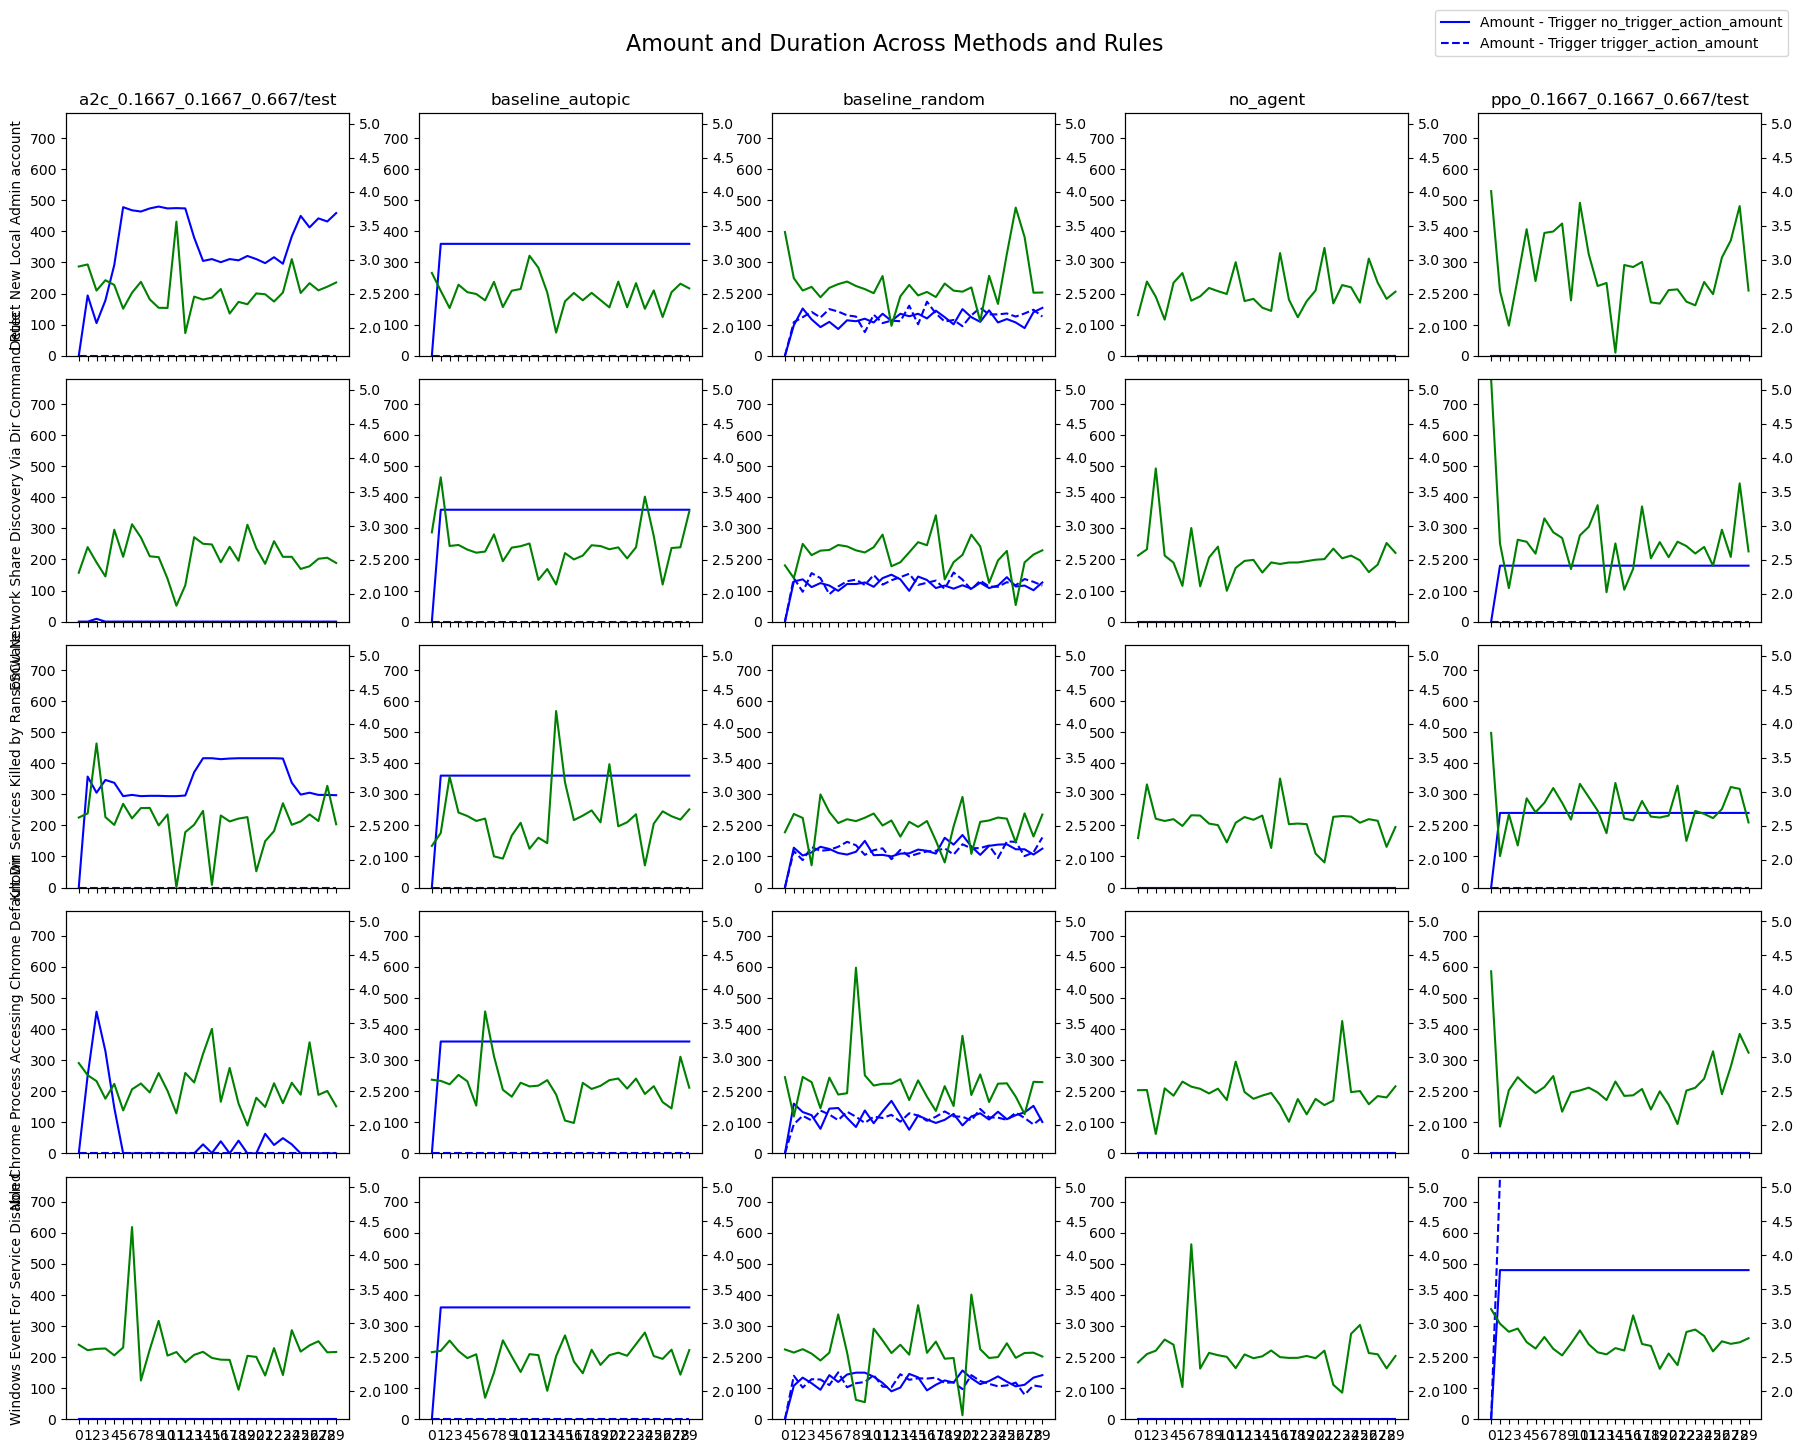

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming x is your DataFrame
# Example data:
# x = ...
linestyle_dict = {'no_trigger_action_amount': '-', 'trigger_action_amount': '--'}
# Sort the DataFrame by 'time'
x = x.sort_values(by=['method', 'rule_name', 'time'])

# Create separate subplots for each facet
fig, axes = plt.subplots(nrows=x['rule_name'].nunique(), ncols=x['method'].nunique(), figsize=(18, 15), sharex=True, sharey='col')

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Calculate global max and min values for 'act_amount' and 'duration'
global_max_amount = x['act_amount'].max()
global_min_amount = x['act_amount'].min()
global_max_duration = x['duration'].max()
global_min_duration = x['duration'].min()

# Iterate over facets and plot on each subplot
for i, rule_name in enumerate(x['rule_name'].unique()):
    for j, method in enumerate(x['method'].unique()):
        subset = x[(x['method'] == method) & (x['rule_name'] == rule_name)]

        # Plot 'act_amount' on the left y-axis with NaN for trigger field change
        for trigger_field, group in subset.groupby('action_type'):
            axes[i * len(x['method'].unique()) + j].plot(group['time'], group['act_amount'], label=f'Amount - Trigger {trigger_field}', linestyle=linestyle_dict[trigger_field], color='blue')

            # Add NaN to create a gap between trigger field changes
            axes[i * len(x['method'].unique()) + j].plot(group['time'].iloc[-1:], np.repeat([None], len(group['time'].iloc[-1:])), color='white')

        # Create a twin y-axis for 'duration' on the right
        axes2 = axes[i * len(x['method'].unique()) + j].twinx()
        axes2.plot(subset['time'], subset['duration'], label='Duration', color='green')

        # Set y-axis limits based on global max and min values
        axes[i * len(x['method'].unique()) + j].set_ylim([global_min_amount, global_max_amount])
        axes2.set_ylim([global_min_duration, global_max_duration])

        # Add column titles
        if i == 0:
            axes[j].set_title(method)

# Add row title
for i, rule_name in enumerate(x['rule_name'].unique()):
    axes[i * len(x['method'].unique())].set_ylabel(rule_name)

# Replace x-axis labels with scalar indices
for ax in axes[-len(x['method'].unique()):]:
    ax.set_xticks(range(len(x['time'].unique())))
    ax.set_xticklabels(range(len(x['time'].unique())))

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Overall title
fig.suptitle('Amount and Duration Across Methods and Rules', fontsize=16)

# Combine legends and place at the top right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles ,labels, loc='upper right', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


In [1]:
import gym
import custom_splunk
gym.make('splunk-v0')

TypeError: __init__() missing 3 required positional arguments: 'fake_start_datetime', 'reward_parameters', and 'is_measure_energy'

In [3]:
gym.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'splunk-v0'])

In [ ]:
! pip install --upgrade matplotlib

Could not fetch URL https://pypi.org/simple/matplotlib/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/matplotlib/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)'))) - skipping
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)'))) - skipping


In [140]:
alt.Chart(time_rules_energy_df).mark_line(color='green', point=True).encode(
    x='index',
    y='duration',
    color='method',
    row='rule_name'

).properties(
    title='Energy consumption of the DRL method vs the baseline methods',
    width=800,
)

alt.Chart(...)

/tmp/ipykernel_12198/890478132.py:61: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax2.set_ylim(y2_min, y2_max)
/tmp/ipykernel_12198/890478132.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


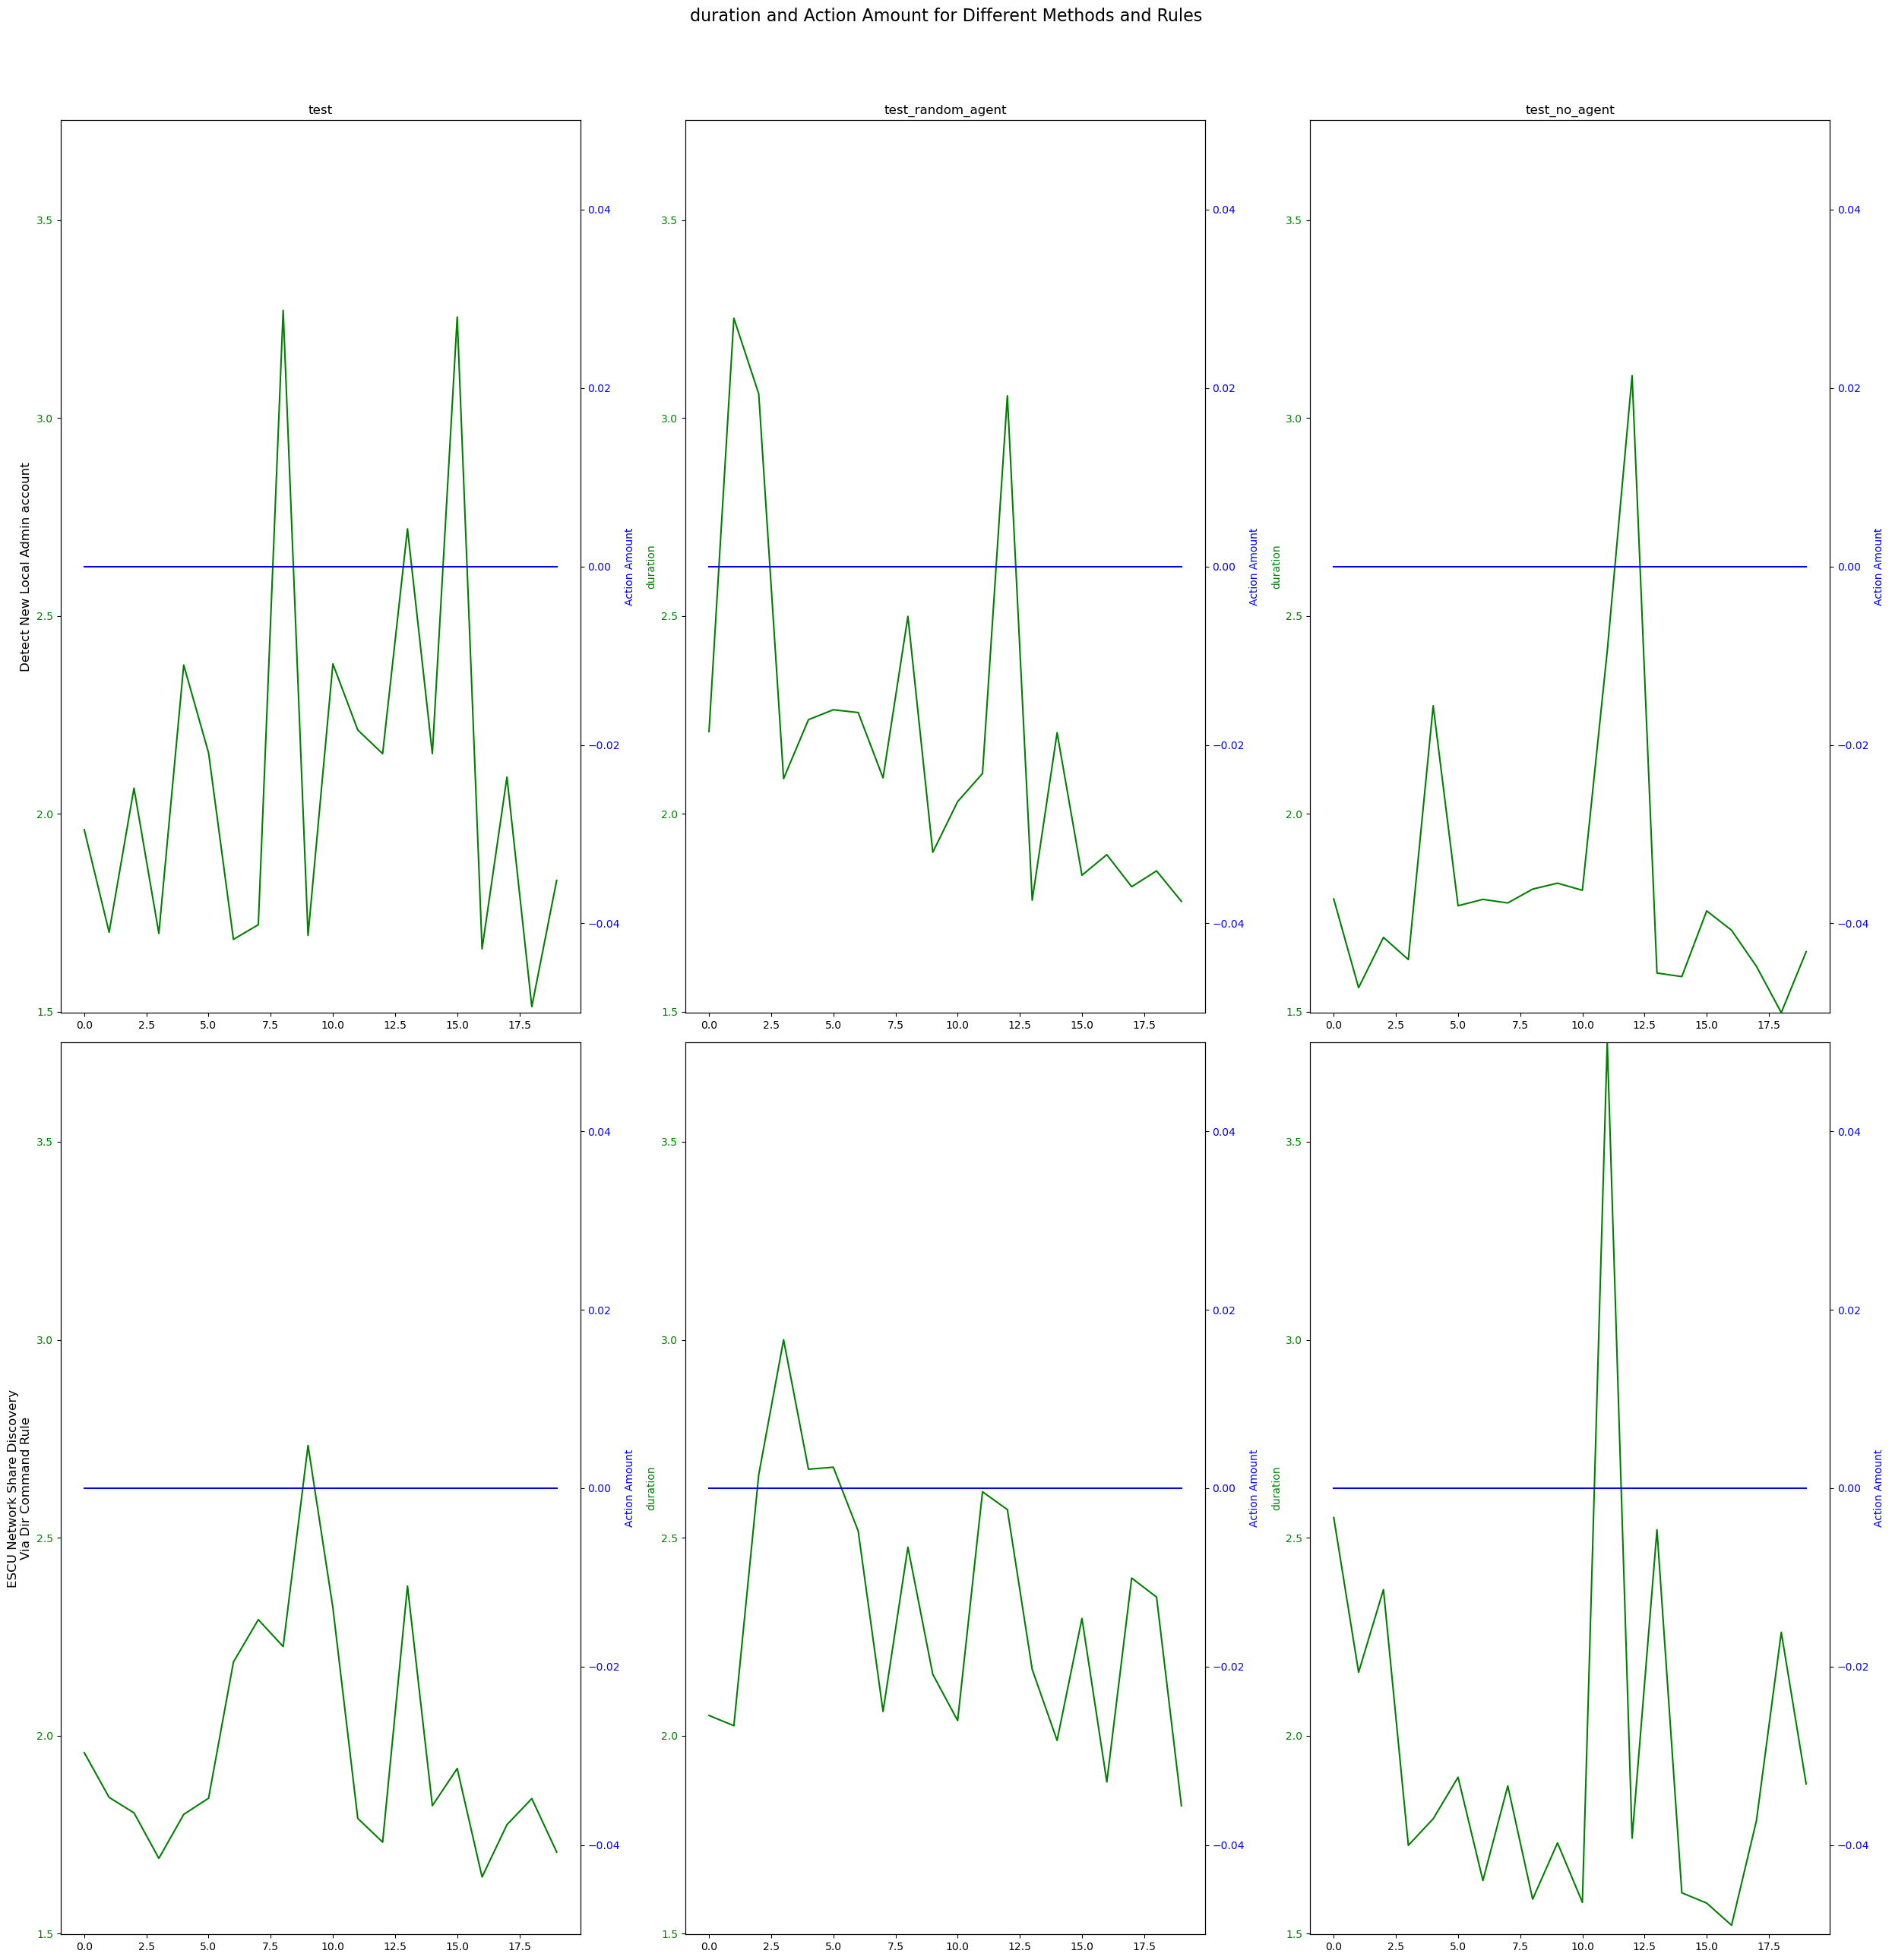

In [ ]:
import matplotlib.pyplot as plt

rule_names = time_rules_energy_df['rule_name'].unique()
methods = time_rules_energy_df['method'].unique()
n_rows = len(rule_names)
n_cols = len(methods)

# Function to add line breaks to longer labels
def add_line_breaks(text, max_length=30):
    words = text.split()
    lines = []
    current_line = []
    current_length = 0

    for word in words:
        if current_length + len(word) + len(current_line) - 1 > max_length:  # + len(current_line) - 1 for spaces
            lines.append(' '.join(current_line))
            current_length = 0
            current_line = []
        current_line.append(word)
        current_length += len(word)

    lines.append(' '.join(current_line))
    return '\n'.join(lines)

# Apply the function to the rule names
formatted_rule_names = [add_line_breaks(rule) for rule in rule_names]

fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 25), constrained_layout=True)

# Setting column titles for methods
for ax, col in zip(axs[0], methods):
    ax.set_title(col)

# get y_min y_maxx y2_min y2_max
y_min, y_max = time_rules_energy_df['duration'].min(), time_rules_energy_df['duration'].max()
y2_min, y2_max = time_rules_energy_df['action_amount'].min(), 1.5*time_rules_energy_df['action_amount'].max()

# Iterate over each subplot and plot the data
for row, rule_name in enumerate(rule_names):
    for col, method in enumerate(methods):
        ax1 = axs[row, col]
        
        # Filter data for the current method and rule_name
        filtered_data = time_rules_energy_df[(time_rules_energy_df['method'] == method) & 
                                             (time_rules_energy_df['rule_name'] == rule_name)].sort_values(by=['index'])
        
        # Plot the first data (energy) on the primary y-axis
        ax1.plot(filtered_data['index'], filtered_data['duration'], color='green', label='duration')
        ax1.set_ylabel('duration', color='green')
        ax1.tick_params(axis='y', labelcolor='green')
        ax1.set_ylim(y_min, y_max)
        
        # Create a secondary y-axis for the subplot
        ax2 = ax1.twinx()
        
        # Plot the second data (action_amount) on the secondary y-axis
        ax2.plot(filtered_data['index'], filtered_data['action_amount'], color='blue', label='action_amount')
        ax2.set_ylabel('Action Amount', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.set_ylim(y2_min, y2_max)
        
        # Set formatted rule_name as the y-label for the first column, without rotation
        if col == 0:
            ax1.set_ylabel(formatted_rule_names[row], size='large', color='black')

# Set an overall title for the entire figure
plt.suptitle("duration and Action Amount for Different Methods and Rules", y=1.03, fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
alt.Chart(time_rules_energy_df.sort_values(by=['energy'], ascending=False)).mark_line(color='green', point=True).encode(
    x=alt.X('action_amount', sort=alt.EncodingSortField(field="energy", op="sum", order='ascending')),
    y='energy',
    color=alt.Color('rule_name', sort='-y', scale=alt.Scale(scheme='category20')),

)

KeyError: 'energy'

In [ ]:
base = alt.Chart(time_rules_energy_df).encode(x='index')

# Chart for energy
e = base.mark_line(color='green').encode(
    y=alt.Y('energy', axis=alt.Axis(title='Energy', orient='left'))
)

# Chart for action amount with its own y-axis on the right
a = base.mark_line(color='blue').encode(
    y=alt.Y('action_amount', axis=alt.Axis(title='Action Amount', orient='right'))
)

# Combine the charts and facet them
chart = (e + a).facet(
    column='method',
    row='rule_name'
).resolve_scale(
    y='independent'
).properties(
    title='Energy consumption of the DRL method vs the baseline methods'
)

chart


alt.FacetChart(...)

In [ ]:
import xml.etree.ElementTree as ET
from socfaker import SocFaker
from lxml import etree

sc = SocFaker()
# log = sc.logs.windows.eventlog(1, event_code_list=[5140])
log = sc.logs.windows.sysmon(1, event_code_list=[3])
xml_data = b"<?xml version=\"1.0\" encoding=\"utf-8\" standalone=\"yes\"?>\n<Events>\n"
for event in log:
    event = event.encode("utf-8")
    event = etree.fromstring(event)
    xml_data += etree.tostring(event, encoding='utf8', method='xml')
    xml_data += b"\n"
xml_data += b"</Events>"
with open('xml_file_name2.xml', "wb") as fe:
        fe.write(xml_data)

In [ ]:
result_text

'\n \n  \n  \n   5633\n  \n   0\n  \n   Desktop-FOJR9AB\n  \n   1\n  \n   11758\n  \n  \n   2526\n  \n  \n  \n   Microsoft Hyper-V Network Adapter\n  \n   -\n  \n   -\n  \n   -\n  \n   0x0\n  \n   0x70003\n  \n   The network does not support authentication\n  '

[<?xml version="1.0" encoding="utf-8"?>
 <Event><System><Provider Guid="2256d4dc-9b1d-4faf-aeef-adf47b04c039" Name="Microsoft-Windows-UAC"></Provider><EventId>5633</EventId><Version>1</Version><Computer>Desktop-RR8BTKW</Computer><Level>1</Level><Task>12740</Task><TimeCreated SystemTime="2022-09-06T06:03:36.328756+03:00"></TimeCreated><EventRecordID>3633</EventRecordID><Execution ProcessID="2" ThreadID="450"></Execution></System><EventData><InterfaceName>Microsoft Hyper-V Network Adapter</InterfaceName><Identity>-</Identity><SubjectUserName>-</SubjectUserName><SubjectDomainName>-</SubjectDomainName><SubjectLogonId>0x0</SubjectLogonId><ReasonCode>0x70003</ReasonCode><ReasonText>The network does not support authentication</ReasonText></EventData></Event>,
 <?xml version="1.0" encoding="utf-8"?>
 <Event><System><Provider Guid="54988419-9039-496d-900f-8473db1b19ae" Name="spbcx"></Provider><EventId>5633</EventId><Version>1</Version><Computer>Desktop-RR8BTKW</Computer><Level>3</Level><Task>12

In [ ]:

''.format({'sd':1, 'sdf':2, 'sdf':3})

''

In [ ]:
import json

xml_data = sc.logs.windows.eventlog(1, event_code_list=[5140])

splunk_event = {
    "time": "2021-06-04T06:25:54.170835+03:00",
    "host": "Desktop-605IHDW",
    "source": "C:\\\\Documents",
    "event": xml_data[0]
}

print(json.dumps(splunk_event))

{"time": "2021-06-04T06:25:54.170835+03:00", "host": "Desktop-605IHDW", "source": "C:\\\\Documents", "event": "<?xml version=\"1.0\" encoding=\"utf-8\"?>\n<Event>\n <System>\n  <Provider Guid=\"6a4c1f3b-ddae-4097-b604-5e01c1f19e4e\" Name=\"Microsoft-Windows-Security-EnterpriseData-FileRevocationManager\">\n  </Provider>\n  <EventId>\n   5140\n  </EventId>\n  <Version>\n   0\n  </Version>\n  <Computer>\n   Laptop-47UXL1Q\n  </Computer>\n  <Level>\n   3\n  </Level>\n  <Task>\n   12144\n  </Task>\n  <TimeCreated SystemTime=\"2022-10-19T05:24:52.931286+03:00\">\n  </TimeCreated>\n  <EventRecordID>\n   2607\n  </EventRecordID>\n  <Execution ProcessID=\"13\" ThreadID=\"392\">\n  </Execution>\n </System>\n <EventData>\n  <SubjectUserSid>\n   S-1-5-21-3457937927-2839227994-823803824-1104\n  </SubjectUserSid>\n  <SubjectUserName>\n   dadmin\n  </SubjectUserName>\n  <SubjectDomainName>\n   CONTOSO\n  </SubjectDomainName>\n  <SubjectLogonId>\n   0x541f35\n  </SubjectLogonId>\n  <ObjectType>\n   F

In [ ]:


import re
CPU_TDP = 200

path = '/home/shouei/GreenSecurity-FirstExperiment/SplunkResearch/VMware, Inc. Linux 3.10.0-1160.88.1.el7.x86_64/Splunk Enterprise SIEM/Power Saver Plan/One Scan'
last = 454
num_of_measurements = 16
rng = range(last-num_of_measurements+1, last+1 )
dirs = {f'Measurement {i}'for i in rng}
measurement_dirs = sorted([d for d in os.listdir(path) if d in dirs])
# measurement_dirs = sorted([d for d in os.listdir(path) if d.startswith('Measurement')])
dfs=[]
action_list = []
time_field = 'Time(sec)'
for measurement_dir in measurement_dirs:
    measurement_path = os.path.join(path, measurement_dir)
    rules_enegry_path = os.path.join(measurement_path, 'rules_energy.csv')
    rules_energy_df = pd.read_csv(rules_enegry_path)
    with open(os.path.join(measurement_path, 'action.txt'), 'r') as f:
        action = f.read()
    # transform the action string to a list of integers
    action = [i.strip('\n').strip(' ') for i in re.split(',| ',action[1:-1])]
    action = [int(i) for i in action if i != '']
    action_list.append(action)     
    if rules_energy_df.empty:
        continue
    print(measurement_dir)
    # create a new column for the time interval
    rules_energy_df[time_field] = pd.to_datetime(rules_energy_df[time_field])
    # Get start time
    start_time = rules_energy_df[time_field].min()
    rules_energy_df = rules_energy_df.sort_values(by=['name', time_field])
    # get difference between each time interval in seconds grouped by name
    rules_energy_df['delta_time'] = rules_energy_df.groupby('name')[time_field].diff().dt.total_seconds().fillna(0)
    # create a new column for the integral of the cpu using the trapezoidal rule
    # grouped_rules_energy_df = rules_energy_df.groupby('name').apply(lambda g: integrate.simpson(g['CPU(%)'], x=g['delta_time']))
    # grouped_rules_energy_df = grouped_rules_energy_df.reset_index().rename(columns={0: 'cpu_integral'})
    rules_energy_df['CPU(W)'] = rules_energy_df['CPU(%)'] * CPU_TDP / 100
    rules_energy_df['CPU(J)'] = rules_energy_df['CPU(W)'] * rules_energy_df['delta_time']
    grouped_rules_enegry_df = rules_energy_df.groupby('name')['CPU(J)'].sum().reset_index()
    # create a chart for the cpu usage using altair
    grouped_rules_enegry_df['measurement'] = measurement_dir
    dfs.append(grouped_rules_enegry_df)
action_df = pd.DataFrame(action_list, columns=log_types_str)
action_df['measurement'] = measurement_dirs
final_df = pd.concat(dfs)



Measurement 439
Measurement 440
Measurement 441
Measurement 442
Measurement 443
Measurement 444
Measurement 445
Measurement 446
Measurement 447
Measurement 448
Measurement 449
Measurement 450
Measurement 451
Measurement 452
Measurement 453
Measurement 454


In [ ]:
rules_energy_df.groupby('name')[time_field].diff().dt.total_seconds().fillna(0)

37    0.000000
38    0.350979
39    0.376344
40    0.262398
41    0.230555
42    0.213279
43    0.149717
44    0.149262
45    0.142408
46    0.141534
47    0.130617
48    0.135719
49    0.130892
50    0.130981
51    0.131114
52    0.131661
14    0.000000
15    0.350979
16    0.376344
17    0.262398
18    0.230555
19    0.213279
20    0.149717
21    0.149262
22    0.142408
23    0.141534
24    0.130617
25    0.135719
26    0.130892
27    0.130981
28    0.131114
29    0.131661
30    0.134456
31    0.110339
32    0.090784
33    0.090137
34    0.116036
35    0.131244
36    0.148410
0     0.000000
1     0.093803
2     0.097629
3     0.114057
4     0.112766
5     0.118372
6     0.147915
7     0.106610
8     0.209148
9     0.356126
10    0.350979
11    0.376344
12    0.262398
13    0.230555
Name: Time(sec), dtype: float64

In [ ]:
# merge helper df with final df
final_df_with_action = pd.merge(final_df, action_df, left_on='measurement', right_on='measurement')
final_df_with_action['action'] =pd.Series([0]*len(final_df_with_action))
for measurement_dir in measurement_dirs:
    if final_df_with_action[final_df_with_action['measurement'] == measurement_dir].empty:
        continue
    if final_df_with_action[final_df_with_action['measurement'] == measurement_dir].loc[:,log_types_str].iloc[0].sum() > 0:
        final_df_with_action.loc[final_df_with_action['measurement'] == measurement_dir, 'action'] = 1

In [ ]:
unique_log_types = {x for y in logtypes_by_rule_dict.values() for x in y}
print(len(unique_log_types))
unique_log_types

28


{'wineventlog:application_1000',
 'wineventlog:security_1100',
 'wineventlog:security_1102',
 'wineventlog:security_2004',
 'wineventlog:security_2005',
 'wineventlog:security_4624',
 'wineventlog:security_4625',
 'wineventlog:security_4634',
 'wineventlog:security_4657',
 'wineventlog:security_4663',
 'wineventlog:security_4688',
 'wineventlog:security_4720',
 'wineventlog:security_4728',
 'wineventlog:security_4732',
 'wineventlog:security_4756',
 'wineventlog:security_5140',
 'wineventlog:security_7045',
 'wineventlog:system_104',
 'wineventlog:system_1074',
 'wineventlog:system_6008',
 'wineventlog:system_7040',
 'xmlwineventlog:microsoft-windows-sysmon/operational_11',
 'xmlwineventlog:microsoft-windows-sysmon/operational_12',
 'xmlwineventlog:microsoft-windows-sysmon/operational_13',
 'xmlwineventlog:microsoft-windows-sysmon/operational_14',
 'xmlwineventlog:microsoft-windows-sysmon/operational_16',
 'xmlwineventlog:microsoft-windows-sysmon/operational_3',
 'xmlwineventlog:micros

In [ ]:
sums = []
for rule, measurement in final_df_with_action[['name', 'measurement']].values:
    try:
        sums.append(final_df_with_action[(final_df_with_action.name == rule)&(final_df_with_action.measurement == measurement)][logtypes_by_rule_dict[rule.lower()]].sum(axis=1).values[0])
    except:
        sums.append(0)
final_df_with_action['relevant_logs_addition'] = sums

In [ ]:
final_df_with_action

,name,CPU(J),measurement,xmlwineventlog:microsoft-windows-sysmon/operational_8,wineventlog:security_2005,wineventlog:security_4624,wineventlog:security_4756,xmlwineventlog:microsoft-windows-sysmon/operational_3,xmlwineventlog:microsoft-windows-sysmon/operational_14,wineventlog:security_1102,...,xmlwineventlog:microsoft-windows-sysmon/operational_11,wineventlog:security_4634,wineventlog:security_4663,wineventlog:system_104,wineventlog:security_4720,wineventlog:security_4625,wineventlog:security_4732,xmlwineventlog:microsoft-windows-sysmon/operational_16,action,relevant_logs_addition
0,Modification of Executable File,120.371748,Measurement 439,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Multiple Network Connections to Same Port on E...,150.353172,Measurement 439,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,New Local Admin Account,47.898942,Measurement 439,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Modification of Executable File,120.503789,Measurement 440,122,760,4,698,92,990,715,...,411,811,285,38,272,373,503,850,1,411
4,Multiple Network Connections to Same Port on E...,153.978820,Measurement 440,122,760,4,698,92,990,715,...,411,811,285,38,272,373,503,850,1,92
5,New Local Admin Account,43.542498,Measurement 440,122,760,4,698,92,990,715,...,411,811,285,38,272,373,503,850,1,775
6,Modification of Executable File,129.968372,Measurement 441,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Multiple Network Connections to Same Port on E...,168.066588,Measurement 441,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,New Local Admin Account,55.170376,Measurement 441,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Modification of Executable File,138.870881,Measurement 442,935,118,857,210,232,82,949,...,281,976,395,322,572,93,694,130,1,281


In [ ]:
chart = alt.Chart(final_df_with_action).mark_line(point=True).encode(
y=alt.Y('CPU(J):Q', axis=alt.Axis(title='CPU energy (J)')),
# row=alt.Column('name:N', header=alt.Header(orient='top', labelFontSize=20)),
color=alt.Color('name:N'),
x=alt.X('relevant_logs_addition:Q', axis=alt.Axis(title=None))
).properties(
title=f'CPU Energy Consumption'
)

chart

alt.Chart(...)

In [ ]:
chart = alt.Chart(final_df_with_action).mark_bar().encode(
y=alt.Y('cpu_integral:Q', axis=alt.Axis(title='CPU Integral')),
row=alt.Column('name:N', header=alt.Header(orient='top', labelFontSize=20)),
color=alt.Color('relevant_logs_addition:Q'),
x=alt.X('measurement:N', axis=alt.Axis(title=None))
).properties(
title=f'CPU Integral'
)

chart
# with alt.data_transformers.enable('default'):
#     chart.save(f'{measurement_path}/graph/cpu_integral.png', engine="altair_saver")
# chart.save(f'{measurement_path}/graphs/cpu_integral.html', embed_options={'renderer':'svg'})

alt.Chart(...)

In [ ]:
results = []
for rule in final_df['name'].unique():
    rule_logtypes = [f"{logtype[0].lower().replace('*', '')}_{logtype[1]}" for logtype in section_logtypes[rule]]
    rule_logtypes = [x.replace('\"', '') for x in rule_logtypes]
    try:
        tmp = final_df_with_action[final_df_with_action['name']==rule][rule_logtypes]
    except:
        tmp = pd.DataFrame()
    results.append(tmp)
logtypes_df = pd.concat(results, axis=1).sort_index()

logtypes_final_df = pd.merge(final_df, logtypes_df, left_index=True, right_index=True)


In [ ]:
logtypes_final_df['added_logs'] = logtypes_final_df.drop(columns=['name','cpu_integral','measurement']).sum(axis=1).astype(np.float64)
logtypes_final_df

KeyError: "['cpu_integral'] not found in axis"

In [ ]:
chart = alt.Chart(logtypes_final_df).mark_point().encode(
y=alt.Y('cpu_integral:Q', axis=alt.Axis(title='CPU Integral')),
row=alt.Column('name:N', header=alt.Header(orient='top', labelFontSize=20)),
x=alt.X('added_logs:Q', axis=alt.Axis(title=None))
).properties(
title=f'CPU Integral'
)
chart

TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

alt.Chart(...)

In [ ]:
# load alert status
# load current distribution
alert_status_list = []
current_distribution_list = []
for measurement_dir in measurement_dirs:
    measurement_path = os.path.join(path, measurement_dir)
    alert_status_path = os.path.join(measurement_path, 'alerts_status.json')
    current_distribution_path = os.path.join(measurement_path, 'current_distribution.json')
    with open(alert_status_path, 'r') as f:
        alert_status = json.load(f)['results']
    with open(current_distribution_path, 'r') as f:
        current_distribution = json.load(f)
    alert_status_list.append(alert_status)
    current_distribution_list.append(current_distribution)

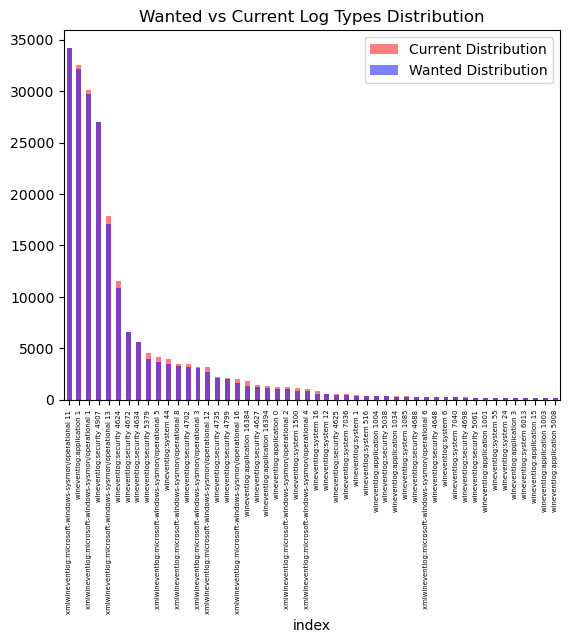

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define figure and axes
fig, ax = plt.subplots()
amount = 50

# Plot second dataframe on the same axis
df2 = pd.DataFrame(index=current_distribution_list[1].keys(), data=current_distribution_list[1].values(), columns=['Current Distribution'])
df2.index = df2.index.str.lower()
df2 = df2.reset_index().groupby('index').sum()
df2.drop(index='total_count').sort_values(by='Current Distribution', ascending=False).head(amount).plot(kind='bar', ax=ax, color='r', label='Current Distribution', alpha=0.5)

# Plot first dataframe on the defined axis
df1 = pd.DataFrame(index=current_distribution_list[0].keys(), data=current_distribution_list[0].values(), columns=['Wanted Distribution'])
df1.index = df1.index.str.lower()
df1 = df1.reset_index().groupby('index').sum()
df1.drop(index='total_count').sort_values(by='Wanted Distribution', ascending=False).head(amount).plot(kind='bar', ax=ax, color='b', label='Wanted Distribution', alpha=0.5)


# Add title and legend
plt.title('Wanted vs Current Log Types Distribution')
plt.legend()

# If needed, rotate x-axis ticks
ax.tick_params(axis='x', which='both', labelsize=5)

plt.show()



<Axes: title={'center': 'Difference between current distribution and wanted distribution'}, xlabel='index'>

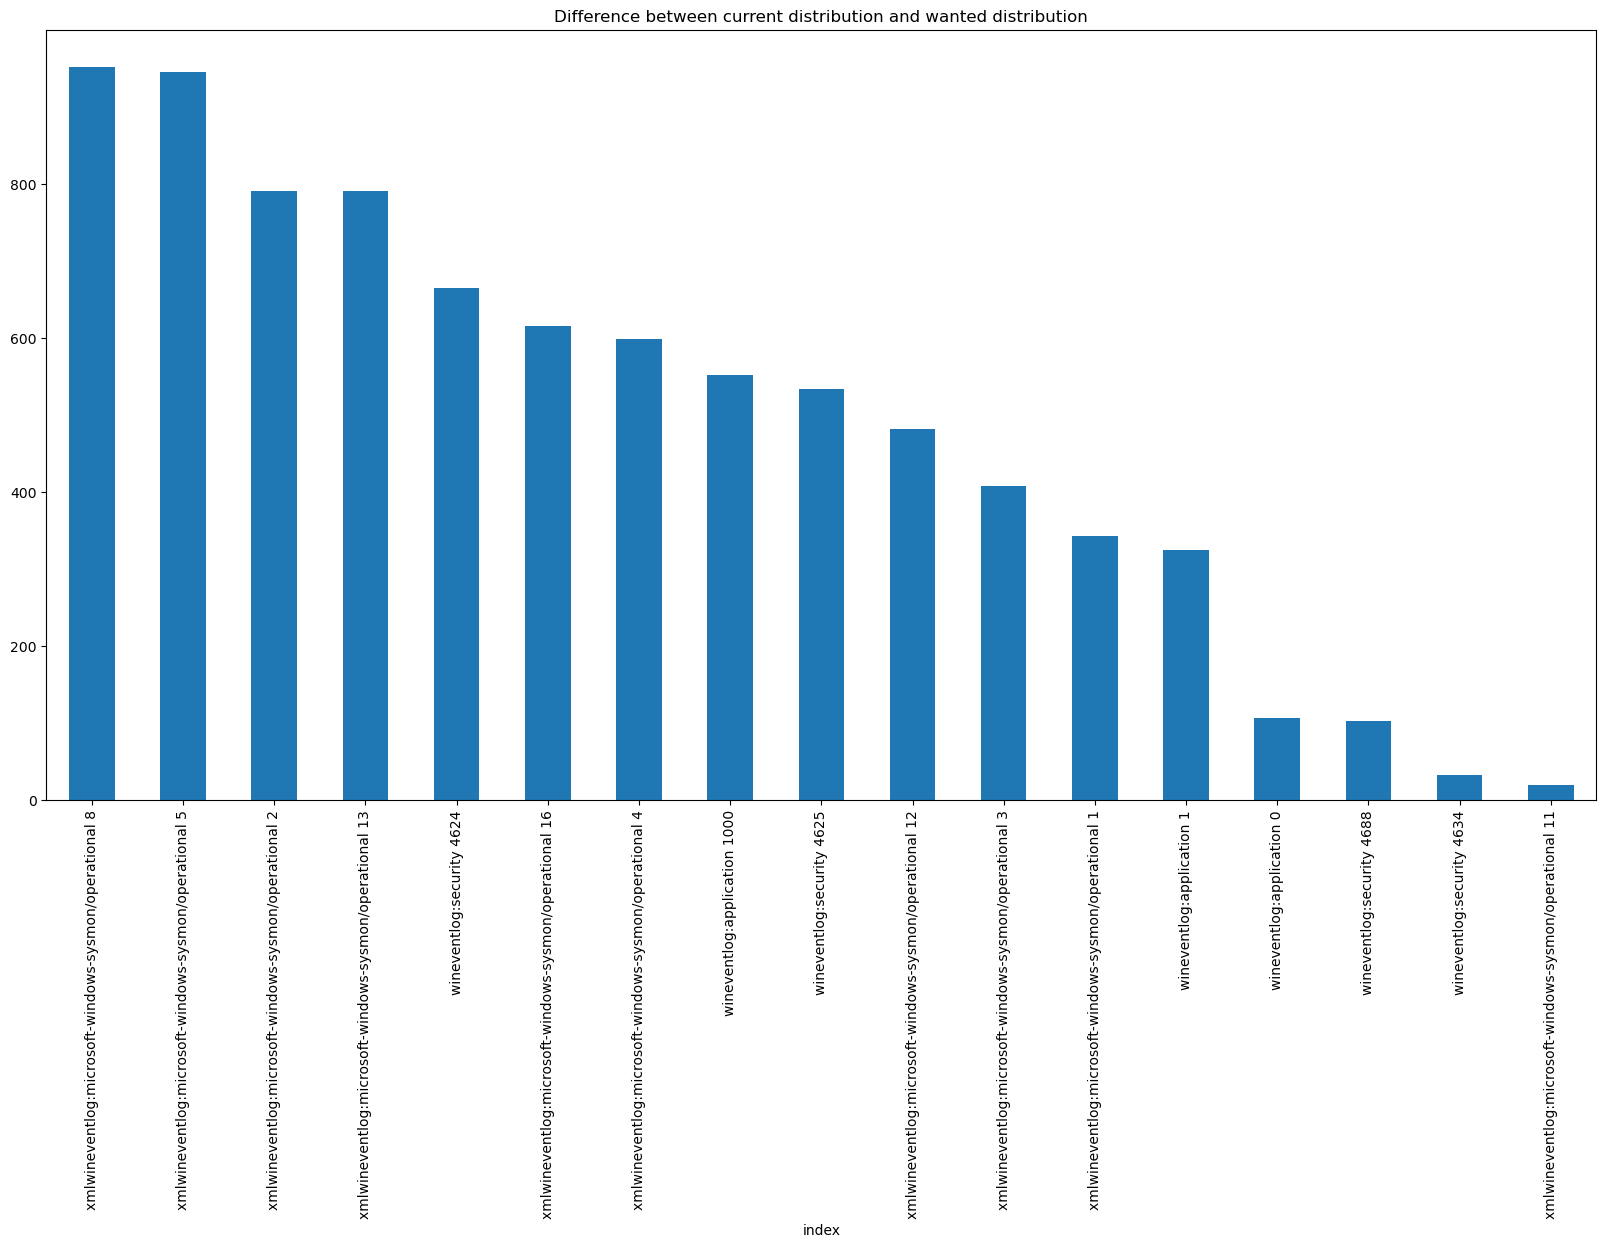

In [ ]:
diff = (df2['Current Distribution']-df1['Wanted Distribution']).drop(index='total_count').sort_values(ascending=False)
diff[diff>0].head(amount).plot(kind='bar', figsize=(20, 10), title='Difference between current distribution and wanted distribution')

In [ ]:
pd.DataFrame(alert_status_list[0]).groupby('savedsearch_name').count()

,sid,count
savedsearch_name,,
An Account Was Logged off,100,100


In [ ]:
rules_enegry_df[rules_enegry_df['name'] == 'An Account Was Logged off']

,Unnamed: 0,Time(sec),PID,PNAME,CPU(%),NUM THREADS,MEMORY(MB),MEMORY(%),READ_IO(#),WRITE_IO(#),READ_IO(KB),WRITE_IO(KB),PAGE_FAULTS,name,sid,pid,time,run_duration,delta_time
10587,10587,2023-07-27 21:19:01.808572,3128,splunkd,19.10,10,85.816,0.54,0,0,0.0,0.0,3864,An Account Was Logged off,scheduler__shouei__search__RMD5d3ffad2ce4319cc...,3128,2023-07-28 00:20:31.483000+03:00,3.012,0.000000
10593,10593,2023-07-27 21:19:02.156383,3128,splunkd,22.98,7,97.625,0.61,702,656,0.0,428.0,6118,An Account Was Logged off,scheduler__shouei__search__RMD5d3ffad2ce4319cc...,3128,2023-07-28 00:20:31.483000+03:00,3.012,0.347811
10599,10599,2023-07-27 21:19:02.394416,3128,splunkd,0.00,7,97.625,0.61,0,0,0.0,0.0,0,An Account Was Logged off,scheduler__shouei__search__RMD5d3ffad2ce4319cc...,3128,2023-07-28 00:20:31.483000+03:00,3.012,0.585844
10605,10605,2023-07-27 21:19:02.708890,3128,splunkd,0.00,7,97.625,0.61,1,0,0.0,0.0,0,An Account Was Logged off,scheduler__shouei__search__RMD5d3ffad2ce4319cc...,3128,2023-07-28 00:20:31.483000+03:00,3.012,0.900318
10611,10611,2023-07-27 21:19:03.052606,3128,splunkd,0.00,7,97.625,0.61,0,0,0.0,0.0,0,An Account Was Logged off,scheduler__shouei__search__RMD5d3ffad2ce4319cc...,3128,2023-07-28 00:20:31.483000+03:00,3.012,1.244034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15093,15093,2023-07-27 21:23:58.186701,3128,splunkd,0.00,8,133.996,0.84,1,1,0.0,0.0,0,An Account Was Logged off,scheduler__shouei__search__RMD5d3ffad2ce4319cc...,3128,2023-07-28 00:20:31.483000+03:00,3.012,296.378129
15099,15099,2023-07-27 21:23:58.599016,3128,splunkd,0.00,8,133.996,0.84,0,0,0.0,0.0,0,An Account Was Logged off,scheduler__shouei__search__RMD5d3ffad2ce4319cc...,3128,2023-07-28 00:20:31.483000+03:00,3.012,296.790444
15105,15105,2023-07-27 21:23:59.000894,3128,splunkd,0.00,8,133.996,0.84,0,0,0.0,0.0,0,An Account Was Logged off,scheduler__shouei__search__RMD5d3ffad2ce4319cc...,3128,2023-07-28 00:20:31.483000+03:00,3.012,297.192322
15111,15111,2023-07-27 21:23:59.397442,3128,splunkd,0.00,8,133.996,0.84,0,0,0.0,0.0,0,An Account Was Logged off,scheduler__shouei__search__RMD5d3ffad2ce4319cc...,3128,2023-07-28 00:20:31.483000+03:00,3.012,297.588870


In [ ]:
charts[1]

alt.Chart(...)

Merge when the rules running one after an other with a delay

Merge when all the rules running in the same time

In [ ]:
relevant_processes_pid_names_grouped_dict = {}
relevant_processes_pid_names_mean_windows_dict = {}
relevant_names_inegral_dict = {}
path = '/home/shouei/GreenSecurity-FirstExperiment/VMware, Inc. Linux 3.10.0-1160.88.1.el7.x86_64/Splunk Enterprise SIEM/Power Saver Plan/One Scan'

# path = fr"../../Repositories/GreenSecurity-FirstExperiment/Dell Inc. Linux 5.15.0-70-generic/Splunk Enterprise SIEM/Power Saver Plan/One Scan/"
for measurment_name in measurement_dirs:
    pid_1_times = set(exp_dfs[measurment_name].groupby('pid').count().dropna().index)
    name_1_times = exp_dfs[measurment_name].where(lambda x: x.pid.isin(pid_1_times))[['name','pid']]
    relevant_processes = dfs[measurment_name].where(lambda x: x.PID.isin(pid_1_times))
    relevant_processes_pid_names = pd.merge(relevant_processes, name_1_times, left_on='PID', right_on='pid')
    
    # Get start time
    start_time = relevant_processes_pid_names['Time(sec)'].min()
    # Calculate delta time in seconds
    relevant_processes_pid_names['delta_time'] = (relevant_processes_pid_names['Time(sec)'] - start_time).dt.total_seconds()
    print(len(relevant_processes_pid_names)/relevant_processes_pid_names['delta_time'].max())
    #####Create a chart########
    # Create the dropdown menu selection
    name_selection = alt.selection_multi(fields=['name'], bind='legend')
    # Define the chart
    chart = alt.Chart(relevant_processes_pid_names).mark_line(interpolate='linear').encode(
            alt.Y("CPU(%):Q"),
            alt.X(f"delta_time:Q"),
            alt.Color('name:N', scale=alt.Scale(scheme='category20')),
            opacity=alt.condition(name_selection, alt.value(1), alt.value(0.1))
        ).properties(
            width=1500,
            height=500
        ).add_selection(name_selection).configure_legend(
            orient='bottom',
            labelLimit=10000,
            columns=4,
            labelFontSize=15
        )
    with alt.data_transformers.enable('default'):
        chart.save(f"{path}/{measurment_name}/graphs/interactive_line.html")
    ##########################
    
    #####Create a chart########
    rule_chart = alt.Chart(relevant_processes_pid_names).mark_rule(strokeDash=[5, 5]).encode(
    x='min(Time(sec)):T',color='name'
    )

    c2 = alt.Chart(relevant_processes_pid_names).mark_line(interpolate='linear').encode(
            alt.Y("CPU(%):Q"),
            alt.X(f"Time(sec):T"),
        ).properties(
            width=1000,
            height=500
        )
    mean_chart = alt.Chart(relevant_processes_pid_names).mark_rule(color='red', strokeDash=[5, 5]).encode(
        y='mean(CPU(%)):Q'
    )

    chart2 = (c2+rule_chart+mean_chart).configure_legend(
                labelLimit=10000,
                labelFontSize=15
            )
    with alt.data_transformers.enable('default'):
        chart2.save(f"{path}/{measurment_name}/graphs/total_cpu.html")
    ##########################
    
    relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
    relevant_processes_pid_names_grouped_dict[measurment_name] = relevant_processes_pid_names_grouped
    #integral by name of cpu over time
    relevant_names_inegral_dict[measurment_name] = relevant_processes_pid_names.groupby('name').apply(lambda g: integrate.trapz(g['CPU(%)'], x=g['delta_time']))

    
    # # Define the time window size in minutes
    # time_window_size = 1
    # last_sec = int(np.ceil(relevant_processes_pid_names['delta_time'].max()))
    # # Create an empty column to store the mean values
    # relevant_processes_pid_names['mean_col'] = pd.Series()
    # relevant_processes_pid_names['time_window'] = pd.Series()

    # # Iterate over the time series data, and calculate the mean for each time window
    # for i in range(last_sec):
    #     start_time = i
    #     end_time = start_time + time_window_size
    #     window_data = relevant_processes_pid_names[(relevant_processes_pid_names['delta_time'] >= start_time) & (relevant_processes_pid_names['delta_time'] < end_time)]
    #     mean_values = window_data.groupby('name')['CPU(%)'].mean()
    #     for name in mean_values.index:
    #         relevant_processes_pid_names.loc[window_data[window_data['name']==name].index, 'mean_col'] = mean_values[mean_values.index==name][0]
    #         relevant_processes_pid_names.loc[window_data[window_data['name']==name].index, 'time_window'] = i
    
    relevant_processes_pid_names_mean_windows_dict[measurment_name] = relevant_processes_pid_names
    




0.5359004292260336


/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated

1.21280086132766


/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


2.285388620921543


/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


4.056956413913548


/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


3.339743747407611


/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


5.089862516146461


/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


0.39431788230838805


/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


1.1417154205510107


/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


2.6193778406982773


/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


3.673095300180463


/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


3.6134186917275453


/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


6.348101642474566


/tmp/ipykernel_27109/1033965186.py:64: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


In [ ]:
import itertools


times = ['12', '24', '36', '48', '60', '72']
field_state = ['disable', 'enable']
# num_of_experiments = 6
# create all the permutations of the times and field_state as concatinated strings
durations = [f"{field} {time}" for time, field in itertools.product(field_state, times)]
durations

['12 disable',
 '24 disable',
 '36 disable',
 '48 disable',
 '60 disable',
 '72 disable',
 '12 enable',
 '24 enable',
 '36 enable',
 '48 enable',
 '60 enable',
 '72 enable']

In [ ]:
# pid_df = pd.DataFrame([[k]+s for k, v in pids[curr_measurement].items() for s in v], columns=['name', 'sid', 'pid', 'time', 'run_duration']) 
# pid_df.time = pd.to_datetime(pid_df.time)
# # group by time with 10 minutes interval and take the min value of each group
# pid_df.groupby(pd.Grouper(key='time', freq='10min')).min().index
# # pid_df.groupby('time').min()

In [ ]:
def get_searches_times(pid_dict):
    pid_df = pd.DataFrame([[k]+s[:4] for k, v in pid_dict.items() for s in v], columns=['name', 'sid', 'pid', 'time', 'run_duration'])        
    pid_df.time = pd.to_datetime(pid_df.time)
    # group by time with 10 minutes interval and take the min value of each group
    search_times = pid_df.groupby(pd.Grouper(key='time', freq='10min')).min().index
    return pid_df, search_times

In [ ]:
import subprocess
import datetime
import concurrent.futures
import json
os.makedirs("logs_types_info", exist_ok=True)
if not os.path.exists(f'logs_types_info/logs_len_list_{rng[0]}_{rng[-1]}.json'):
    dirs = {f'Measurement {i}' for i in rng}
    logs_len_list = {}
    j = rng[0]
    last_j = rng[-1]+1
    def run_command(command):
        cmd = subprocess.run(command, shell=True, capture_output=True, text=True)
        output = cmd.stdout
        print(output)
        # Parse the output to get the number.
        # num = int(output.split('\n')[2].strip()) if len(output.split('\n')) > 2 else output
        res_dict = {}
        if len(cmd.stdout.split('\n')) > 2:
            for row in cmd.stdout.split('\n')[2:-1]:
                row = row.split()
                source = row[0]
                event_code = row[1]
                count = row[2]
                total_count = row[3]
                res_dict[f"{source} {event_code}"] = int(count)
            res_dict['total_count'] = int(total_count)
        return res_dict

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_command = {}
        # for state in field_state:
        for time in times:
            curr_measurement = f"Measurement {j}"
            path = fr"./VMware, Inc. Linux 3.10.0-1160.88.1.el7.x86_64/Splunk Enterprise SIEM/Power Saver Plan/One Scan/{curr_measurement}"
            # convert pids values to df
            pid_df, search_times = get_searches_times(pids[curr_measurement])
            end_time = "06/15/2023:08:00:00"
            # end_time = datetime.datetime.strptime(end_time, '%m/%d/%Y:%H:%M:%S')
            start_time = time
            start_time = (datetime.datetime.strptime(end_time, '%m/%d/%Y:%H:%M:%S') - datetime.timedelta(hours=int(start_time.split('h')[0]))).strftime('%m/%d/%Y:%H:%M:%S')
            command = f'echo | sudo -S -E env "PATH=$PATH" splunk search "index=main (earliest="{start_time}" latest="{end_time}")|stats count by source EventCode | eventstats sum(count) as totalCount" -maxout 0 -auth shouei:'
            print(command)
            future_to_command[executor.submit(run_command, command)] = (command, time)   

            j += 1
            if j == last_j:                
                break
        for future in concurrent.futures.as_completed(future_to_command):
            command, time = future_to_command[future]
            try:
                data = future.result()
            except Exception as exc:
                print(f'{command} generated an exception: {exc}')
            else:
                logs_len_list[time] = data
    # save the logs_len_list to a json file
    with open(f'logs_types_info/logs_len_list_{rng[0]}_{rng[-1]}.json', 'w') as f:
        json.dump(logs_len_list, f)
else: 
    # load the logs_len_list from a json file
    with open(f'logs_len_list_{rng[0]}_{rng[-1]}.json', 'r') as f:
        logs_len_list = json.load(f)

Log entry successfully sent to Splunk.


/home/shouei/anaconda3/envs/py38/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '132.72.81.150'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [ ]:
import pytz


dirs = {f'Measurement {i}'for i in rng}
integral_list = []
j = rng[0]
i = 0
for state in field_state:
    for time in times:
        # for i in range(num_of_experiments):
        curr_measurement = f"Measurement {j}"
        path = fr"./VMware, Inc. Linux 3.10.0-1160.88.1.el7.x86_64/Splunk Enterprise SIEM/Power Saver Plan/One Scan/{curr_measurement}"
        pid_df, search_times = get_searches_times(pids[curr_measurement])
        g_pid_df = pid_df.groupby(['name', pd.Grouper(key='time', freq='10min')]).min().reset_index()
        for rule_name, val in pids[curr_measurement].items():
            curr_df = relevant_processes_pid_names_mean_windows_dict[curr_measurement]
            curr_df = curr_df[(curr_df['name']==rule_name)]
            if curr_df.empty:
                print(curr_measurement, rule_name)
                continue
            curr_df.loc[:, 'Time(sec)'] = curr_df['Time(sec)'].dt.to_pydatetime()
            curr_df.loc[:, 'Time(sec)'] = curr_df['Time(sec)'].dt.tz_localize('UTC')
            # define the first time of the world
            # date_time = datetime.datetime.fromtimestamp(0, tz=datetime.timezone.utc)
            # s_times = g_pid_df[g_pid_df.name==rule_name].dropna()[['time', 'pid']]
            for v in val:
                # print(j, i)
                # convert v[3] (str date) to datetime in utc
                date_time = datetime.datetime.strptime(v[4], '%Y-%m-%d %H:%M:%S')
                jerusalem = pytz.timezone('Asia/Jerusalem')
                date_time = jerusalem.localize(date_time)
                date_time = date_time.astimezone(pytz.UTC)
                # date_time = datetime.datetime.strptime(v[2], '%Y-%m-%d %H:%M:%S.%f IDT')
                
                # date_time = date_time.replace(hour=date_time.hour-3)
                
                # target_timezone = pytz.timezone('UTC')
                # date_time = date_time.astimezone(target_timezone)
                duration = datetime.timedelta(seconds=v[3])
                name_integral = {}
                pid = v[1]
                # s_time = s_times[s_times.pid==pid].time.values[0]
                df_section = curr_df[(curr_df['pid']==pid)]

                df_section = df_section[(df_section['Time(sec)']>date_time)&(df_section['Time(sec)']<=date_time+duration)]
                if df_section.empty:
                    print(curr_measurement, rule_name, v)
                    continue
                bug = df_section[df_section['WRITE_IO(KB)']<0]
                df_section = df_section.drop(bug.index)
                # if not bug.empty:
                #     print(df_section)
                #     df_section = df_section.loc[:bug.index[0]-1]
                #     print(df_section)
                # df_section['delta_diff'] = df_section['delta_time'].diff()
                # df_section.drop(df_section[df_section['delta_diff']>10].index, inplace=True)
                # df_section = curr_df[(curr_df['Time(sec)']>date_time)]
                # min_date_time = df_section['Time(sec)'].min()
                # df_section = df_section[(df_section['Time(sec)']<=min_date_time+duration)]
                integral_cpu= integrate.simpson(df_section['CPU(%)'], x=df_section['delta_time'])
                disk_w_q= df_section['WRITE_IO(#)'].sum()
                disk_r_q= df_section['READ_IO(#)'].sum()
                disk_w_k= df_section['WRITE_IO(KB)'].sum()
                disk_r_k= df_section['READ_IO(KB)'].sum()
                # integral_disk_w_q= integrate.simpson(df_section['WRITE_IO(#)'], x=df_section['delta_time'])
                # integral_disk_r_q= integrate.simpson(df_section['READ_IO(#)'], x=df_section['delta_time'])
                # integral_disk_w_k= integrate.simpson(df_section['WRITE_IO(KB)'], x=df_section['delta_time'])
                # integral_disk_r_k= integrate.simpson(df_section['READ_IO(KB)'], x=df_section['delta_time'])
                # name_integral[name] = (integral, logs_len_list[i])
                integral_list.append((integral_cpu,disk_w_q,disk_r_q,disk_w_k,disk_r_k, logs_len_list[time]['total_count'], v[3], time, curr_measurement, state, rule_name, pid))
                # date_time = df_section['Time(sec)'].max()
                i += 1
                # print(min_date_time, duration, date_time)
        j += 1


In [ ]:
# list comprehnsion to get the amount of searches
[len([x for v in pids[f'Measurement {i}'].values() for x in v]) for i in rng]

# [x  for x in v for r,v in pids[m].items()  for m in measurement_dirs]

[318, 290, 270, 309, 227, 234, 217, 264, 302, 283, 263, 317]

In [ ]:
df = pd.DataFrame(integral_list, columns=['integral_cpu','disk_w_q','disk_r_q','disk_w_k','disk_r_k','logs_number', 'duration', 'time_range', 'measurment_num', 'state', 'rule_name','pid'])
df = df[df['logs_number'] != '']
# df['normalized_integral'] = df['integral']/df['logs_number']
df

,integral_cpu,disk_w_q,disk_r_q,disk_w_k,disk_r_k,logs_number,duration,time_range,measurment_num,state,rule_name,pid
0,12.572504,354,628,80.0,0.0,70872,1.769,12,Measurement 133,disable,Monitor for Suspicious Network IP’s,29061
1,26.971412,355,457,80.0,0.0,70872,1.951,12,Measurement 133,disable,Monitor for Suspicious Network IP’s,14409
2,9.068992,293,228,72.0,0.0,70872,1.999,12,Measurement 133,disable,Monitor for Suspicious Network IP’s,31740
3,20.843032,354,390,80.0,0.0,70872,1.816,12,Measurement 133,disable,Monitor for Suspicious Network IP’s,16671
4,13.607788,355,679,80.0,0.0,70872,2.005,12,Measurement 133,disable,Monitor for Suspicious Network IP’s,23787
...,...,...,...,...,...,...,...,...,...,...,...,...
3273,3795.762498,1058,51688,2900.0,8.0,1204791,175.280,72,Measurement 144,enable,Monitor for Additions to Firewall Rules,32455
3274,3854.057007,1065,51690,2944.0,0.0,1204791,178.582,72,Measurement 144,enable,Monitor for Additions to Firewall Rules,15719
3275,4000.983685,842,51357,2860.0,0.0,1204791,177.376,72,Measurement 144,enable,Monitor for Additions to Firewall Rules,31759
3276,4063.221131,1060,51687,2920.0,44.0,1204791,176.013,72,Measurement 144,enable,Monitor for Additions to Firewall Rules,16466


In [ ]:
logs_len_dfs = []
for k in logs_len_list:
    source_event_df = pd.DataFrame.from_dict(logs_len_list[k],orient='index', columns=['count']).iloc[:-1]
    source_event_df = source_event_df.reset_index().rename({'index':'source_event'}, axis=1)
    source_event_df[['source','event_code']] = pd.DataFrame(source_event_df['source_event'].apply(lambda x: x.split()).tolist())
    # delete the the lines that are not numbers
    source_event_df = source_event_df[source_event_df['event_code'].str.isnumeric()]
    source_event_df['event_code'] = source_event_df['event_code'].astype(int)
    source_event_df[['source_type','log_name']] = pd.DataFrame(source_event_df['source'].apply(lambda x: x.split(':')).tolist())
    source_event_df['time_range'] = k
    logs_len_dfs.append(source_event_df)
logs_len_df = pd.concat(logs_len_dfs)

In [ ]:
source_event_df['event_code']

0          0
1          1
2       1000
3      10000
4      10001
       ...  
247        3
248        4
249        5
250        6
251        8
Name: event_code, Length: 248, dtype: int64

In [ ]:
alt.Chart(logs_len_df).mark_line().encode(
    alt.X('time_range:N'),
    alt.Y('mean(count):Q'),
    alt.Color('log_name:N', scale=alt.Scale(scheme='category10')),
).properties(
    width=600,
    height=300
)

alt.Chart(...)

In [ ]:

logs_len_df

,source_event,count,source,event_code,source_type,log_name,time_range
0,WinEventLog:Application 0,1927,WinEventLog:Application,0,WinEventLog,Application,48
1,WinEventLog:Application 1,1113,WinEventLog:Application,1,WinEventLog,Application,48
2,WinEventLog:Application 1000,39,WinEventLog:Application,1000,WinEventLog,Application,48
3,WinEventLog:Application 10000,550,WinEventLog:Application,10000,WinEventLog,Application,48
4,WinEventLog:Application 10001,231,WinEventLog:Application,10001,WinEventLog,Application,48
...,...,...,...,...,...,...,...
247,XmlWinEventLog:Microsoft-Windows-Sysmon/Operat...,25983,XmlWinEventLog:Microsoft-Windows-Sysmon/Operat...,3,XmlWinEventLog,Microsoft-Windows-Sysmon/Operational,24
248,XmlWinEventLog:Microsoft-Windows-Sysmon/Operat...,8,XmlWinEventLog:Microsoft-Windows-Sysmon/Operat...,4,NaN,NaN,24
249,XmlWinEventLog:Microsoft-Windows-Sysmon/Operat...,3439,XmlWinEventLog:Microsoft-Windows-Sysmon/Operat...,5,NaN,NaN,24
250,XmlWinEventLog:Microsoft-Windows-Sysmon/Operat...,63,XmlWinEventLog:Microsoft-Windows-Sysmon/Operat...,6,NaN,NaN,24


In [ ]:
alt.Chart(logs_len_df[logs_len_df['log_name']=='Microsoft-Windows-Sysmon/Operational']).mark_arc().encode(
    alt.Color('event_code:N', scale=alt.Scale(scheme='category10')),
    alt.Theta('mean(count):Q'),
)

alt.Chart(...)

In [ ]:
sysmon_logs_amount = logs_len_df[logs_len_df['log_name']=='Microsoft-Windows-Sysmon/Operational'].groupby(['time_range','event_code']).sum().reset_index()
sysmon_logs_amount

/tmp/ipykernel_23522/2944168146.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sysmon_logs_amount = logs_len_df[logs_len_df['log_name']=='Microsoft-Windows-Sysmon/Operational'].groupby(['time_range','event_code']).sum().reset_index()


,time_range,event_code,count
0,12,1,5045
1,12,2,25
2,12,3,870
3,12,4,3
4,12,11,3546
...,...,...,...
66,72,16,2615
67,72,98,119
68,72,255,12
69,72,8020,27


In [ ]:
sysmon_logs_amount

,time_range,event_code,count
0,12,1,5045
1,12,2,25
2,12,3,870
3,12,4,3
4,12,11,3546
...,...,...,...
66,72,16,2615
67,72,98,119
68,72,255,12
69,72,8020,27


In [ ]:
Detected_Registry_Modification_df = df[df['rule_name']=='Detected Registry Modification']
Detected_Registry_Modification_df = Detected_Registry_Modification_df.merge(sysmon_logs_amount, on='time_range')
Detected_Registry_Modification_df['normalized_integral_cpu'] = Detected_Registry_Modification_df['integral_cpu']/Detected_Registry_Modification_df['count']

In [ ]:
Detected_Registry_Modification_df

,integral_cpu,disk_w_q,disk_r_q,disk_w_k,disk_r_k,logs_number,duration,time_range,measurment_num,state,rule_name,pid,event_code,count,normalized_integral_cpu
0,55.057886,161,7832,84.0,0.0,70872,4.077,12,Measurement 133,disable,Detected Registry Modification,16772,1,5045,0.010913
1,55.057886,161,7832,84.0,0.0,70872,4.077,12,Measurement 133,disable,Detected Registry Modification,16772,2,25,2.202315
2,55.057886,161,7832,84.0,0.0,70872,4.077,12,Measurement 133,disable,Detected Registry Modification,16772,3,870,0.063285
3,55.057886,161,7832,84.0,0.0,70872,4.077,12,Measurement 133,disable,Detected Registry Modification,16772,4,3,18.352629
4,55.057886,161,7832,84.0,0.0,70872,4.077,12,Measurement 133,disable,Detected Registry Modification,16772,11,3546,0.015527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,3736.499355,859,66293,4000.0,0.0,1204791,173.381,72,Measurement 144,enable,Detected Registry Modification,31570,16,2615,1.428872
1405,3736.499355,859,66293,4000.0,0.0,1204791,173.381,72,Measurement 144,enable,Detected Registry Modification,31570,98,119,31.399154
1406,3736.499355,859,66293,4000.0,0.0,1204791,173.381,72,Measurement 144,enable,Detected Registry Modification,31570,255,12,311.374946
1407,3736.499355,859,66293,4000.0,0.0,1204791,173.381,72,Measurement 144,enable,Detected Registry Modification,31570,8020,27,138.388865


In [ ]:
Detected_Registry_Modification_df['normalized_integral_cpu'].describe()

count    1409.000000
mean       53.854973
std       120.111778
min         0.005702
25%         0.044199
50%         0.738422
75%        26.713951
max       684.534746
Name: normalized_integral_cpu, dtype: float64

In [ ]:
# show 10 lines of df
pd.set_option('display.max_rows', 50)
df.groupby(['rule_name']).mean().max()
# df.groupby(['rule_name','time_range','state']).count().describe()


/tmp/ipykernel_23522/1114261591.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['rule_name']).mean().max()


integral_cpu      1867.109740
disk_w_q          3305.041667
disk_r_q         30296.758333
disk_w_k        154128.100000
disk_r_k            16.840336
logs_number     643671.312000
duration            84.352059
pid              17137.033058
dtype: float64

In [ ]:
# alt scatters chart of df, shape is time range, x is duration, y is integral, color is rule name and columns is state
alt.Chart(df).mark_circle().encode(
    alt.X('mean(disk_r_k):Q'),
    # alt.X('duration:Q'),
    alt.Y('mean(integral_cpu):Q'),
    alt.Size('mean(duration):Q'),
    alt.Color('rule_name:N', scale=alt.Scale(scheme='category20')),
    # alt.Shape('state:N'),
    alt.Tooltip(['rule_name']),
).properties(
    width=600,
    height=200,
    title='CPU vs Disk KB'
).configure_legend(
    labelLimit=10000,
    labelFontSize=10
)

alt.Chart(...)

In [ ]:
# alt scatters chart of df, shape is time range, x is duration, y is integral, color is rule name and columns is state
alt.Chart(df).mark_circle(size=20).encode(
    alt.X('mean(disk_r_q):Q'),
    # alt.X('duration:Q'),
    alt.Y('mean(integral_cpu):Q'),
    alt.Size('mean(duration):Q'),
    alt.Color('rule_name:N', scale=alt.Scale(scheme='category20')),
    # alt.Shape('state:N'),
    alt.Tooltip(['rule_name']),
).properties(
    width=600,
    height=200,
    title='CPU vs Disk #'
).configure_legend(
    labelLimit=10000,
    labelFontSize=10
)

alt.Chart(...)

In [ ]:
alt.Chart(df).mark_bar().encode(
    alt.Y("sum(disk_r_k):Q", title='Disk read by KB'),
    alt.X(f"time_range:N"),
    # alt.Column('rule_name:N'),
    alt.Color('rule_name:N', scale=alt.Scale(scheme='category20')),
    # column='time_range:N'
).properties(
    width=300,
    height=300,
    title='Disk read by KB'
).configure_legend(
    labelLimit=10000,
    labelFontSize=10
)

alt.Chart(...)

In [ ]:
alt.Chart(df).mark_bar().encode(
    alt.Y("mean(disk_r_q):Q"),
    alt.X(f"time_range:N"),
    # alt.Column('rule_name:N'),
    alt.Color('rule_name:N', scale=alt.Scale(scheme='category20')),
    # column='time_range:N'
).properties(
    width=300,
    height=300,
    title='Disk #'
).configure_legend(
    labelLimit=10000,
    labelFontSize=10
)

alt.Chart(...)

In [ ]:
alt.Chart(df).mark_bar().encode(
    alt.Y("mean(integral_cpu):Q", title='CPU Usage (Integral over time)'),
    alt.X(f"time_range:N"),
    # alt.Column('rule_name:N'),
    alt.Color('rule_name:N', scale=alt.Scale(scheme='category20')),
    # column='time_range:N'
).properties(
    width=300,
    height=300,
    title='CPU Integral'
).configure_legend(
    labelLimit=10000,
    labelFontSize=10
)

alt.Chart(...)

In [ ]:
alt.Chart(df).mark_bar().encode(
    alt.Y("mean(integral):Q"),
    alt.X(f"state:N"),
    alt.Row('rule_name:N'),
    # alt.Color('rule_name:N', scale=alt.Scale(scheme='category20')),
    column='time_range:N'
).properties(
    width=100,
    height=300
).configure_legend(
    labelLimit=10000,
    labelFontSize=10
)

alt.Chart(...)

In [ ]:
# step = 1

# dirs = {f'Measurement {i}'for i in rng}
# for i in rng:
#     if i == step:
#         break
#     first_measurment = f'Measurement {i}'
#     sec_measurment = f'Measurement {i+step}'
#     first_relevant_processes_pid_names = relevant_processes_pid_names_mean_windows_dict[first_measurment]
#     sec_relevant_processes_pid_names = relevant_processes_pid_names_mean_windows_dict[sec_measurment]
    
#     rule_chart_first = alt.Chart(first_relevant_processes_pid_names).mark_rule(strokeDash=[5, 5]).encode(
#         x='min(delta_time):Q',color='name'
#     )

#     c2_first = alt.Chart(first_relevant_processes_pid_names).mark_line(interpolate='linear').encode(
#             alt.Y("CPU(%):Q"),
#             alt.X(f"delta_time:Q"),
#         ).properties(
#             width=1000,
#             height=500
#         )
#     mean_chart_first = alt.Chart(first_relevant_processes_pid_names).mark_rule(color='blue', strokeDash=[5, 5]).encode(
#         y='mean(CPU(%)):Q'
#     )
#     rule_chart_sec = alt.Chart(sec_relevant_processes_pid_names).mark_rule(strokeDash=[5, 5]).encode(
#         x='min(delta_time):Q',color='name'
#     )

#     c2_sec = alt.Chart(sec_relevant_processes_pid_names).mark_line(color='red',interpolate='linear').encode(
#             alt.Y("CPU(%):Q"),
#             alt.X(f"delta_time:Q"),
#         ).properties(
#             width=1000,
#             height=500
#         )
#     mean_chart_sec = alt.Chart(sec_relevant_processes_pid_names).mark_rule(color='red', strokeDash=[5, 5]).encode(
#         y='mean(CPU(%)):Q'
#     )
#     with alt.data_transformers.enable('default'):
#         (c2_first+rule_chart_first+mean_chart_first+c2_sec+rule_chart_sec+mean_chart_sec).configure_legend(
#                 labelLimit=10000,
#                 labelFontSize=15
#             ).save(f"{path}/{measurment_name}/graphs/compare_cpu.html")

In [ ]:
# # create histogram with mean rule
# hist = alt.Chart(first_relevant_processes_pid_names).mark_bar(color='red', opacity=0.2).encode(
#     alt.X('CPU(%)', bin=alt.Bin(step=0.2)),
#     y='count()'
# )

# mean_rule = alt.Chart(first_relevant_processes_pid_names).mark_rule(color='red').encode(
#     x='mean(CPU(%))'
# )
# # create histogram with mean rule
# hist_sec = alt.Chart(sec_relevant_processes_pid_names).mark_bar(color='green', opacity=0.2).encode(
#     alt.X('CPU(%)', bin=alt.Bin(step=0.2)),
#     y='count()'
# )

# mean_rule_sec = alt.Chart(sec_relevant_processes_pid_names).mark_rule(color='green').encode(
#     x='mean(CPU(%))'
# )

# # combine the two charts
# # combine the two charts and add a legend
# chart = alt.layer(hist, mean_rule, hist_sec, mean_rule_sec).properties(
#     title='Histogram of CPU',
#     width=500,
#     height=300
# )
# chart.configure_axis(
#     gridOpacity=0.5
# ).configure_view(
#     strokeWidth=0
# ).configure_title(
#     fontSize=20,
#     fontWeight='bold'
# ).configure_legend(
#     title=None,
#     labelFontSize=15
# )


In [ ]:
# relevant_processes_pid_names.apply(lambda g: integrate.trapz(g['CPU(%)'], x=g['delta_time']), axis=1)


In [ ]:
# # concatenate the three data frames along the columns axis
# merged_df_line = pd.concat([x.groupby(['name','time_window'])[['mean_col']].mean() for x in relevant_processes_pid_names_mean_windows_dict.values()], axis=1)
# durations = [1,2,3,4]
# num_of_different_durations = len([x for x in durations])
# # select even and odd columns from the 'CPU(%)' columns
# mean_std_df_line = pd.concat([merged_df_line.iloc[:, i::num_of_different_durations].agg(['mean', 'std'], axis=1).add_suffix('_'+str(durations[i])) for i in range(num_of_different_durations)], axis=1)
# # mean_std_df.iloc[:, 0:2].columns = mean_std_df.iloc[:, 0:2].add_suffix('_odd').columns
# # mean_std_df.iloc[:, 2:4].columns = mean_std_df.iloc[:, 2:4].add_suffix('_even').columns
# # print the final dataframe
# # mean_std_df_line.fillna(0, inplace=True)
# mean_std_df_line


In [ ]:
# mean_df_line = mean_std_df_line[[x for x in mean_std_df_line.columns if x.startswith('mean')]].reset_index().melt(var_name='duration',id_vars='time_window')
# std_df_line =mean_std_df_line[[x for x in mean_std_df_line.columns if x.startswith('std')]].reset_index().melt(var_name='duration',id_vars='time_window')
# mean_df_line[['kind', 'duration']] = mean_df_line.duration.str.split('_', expand=True)
# std_df_line[['kind', 'duration']] = std_df_line.duration.str.split('_', expand=True)

In [ ]:
# df_merged_mean_std = pd.merge(mean_df_line, std_df_line, on=['time_window', 'duration'])
# df_merged_mean_std

In [ ]:
# # reshape dataframe using pivot
# df_pivot = df_merged_mean_std.pivot(index=['time_window', 'duration'], columns=['kind_x','kind_y'], values=['value_x', 'value_y']).reset_index()

# # rename columns
# df_pivot.columns = ['time_window', 'duration', 'mean', 'std']

# print(df_pivot)

In [ ]:
# df_pivot['minus_std'] = df_pivot['mean'] + (-1) * df_pivot['std']
# df_pivot['pluse_std'] = df_pivot['mean'] + df_pivot['std']

In [ ]:
# name_selection = alt.selection_multi(fields=['duration'], bind='legend')
# lines = alt.Chart(df_pivot).mark_line().encode(
#             alt.Y("mean:Q",title='Mean CPU(%)'),
#             alt.X(f"time_window:Q"),
#             alt.Color('duration:N'),
#             opacity=alt.condition(name_selection, alt.value(1), alt.value(0.1)),
#         ).transform_filter(
#     'isValid(datum.mean)'
# )

# # Create the shaded area for the standard deviation
# band = alt.Chart(df_pivot).mark_errorband().encode(
#     alt.Y("pluse_std:Q"),
#     alt.Y2("minus_std:Q"),
#     alt.X(f"time_window:Q"),
#     alt.Color('duration:N'),
#     opacity=alt.condition(name_selection, alt.value(0.2), alt.value(0.02)),
#     # yError="std:Q"
# )
# final_chart = (lines + band).properties(
#             width=1500,
#             height=500,
#             title="Mean and Std CPU usage along the time over 4 duration"
#         ).add_selection(name_selection).configure_legend(
#             labelLimit=10000,
#             columns=4,
#             labelFontSize=15
#         )

In [ ]:
# with alt.data_transformers.enable('default'):
#     final_chart.save(f"interactive_line_all.html")

Merge when all the experiments were ran for the same duration

In [ ]:
# # concatenate the three data frames along the columns axis
# merged_df = pd.concat([x[['CPU(%)']] for x in relevant_processes_pid_names_grouped_dict.values()], axis=1)
# # compute the mean along the index axis
# mean_std_df = merged_df.agg(['mean', 'std'],axis=1)
# print(f"Num of rules: {len(mean_std_df)}")
# mean_std_df

Num of rules: 4


,mean,std
name,,
Increase in # of Hosts Logged int,11.153397,8.899271
New Local Admin Account,8.048684,5.914846
User Login with Local Credentials,12.492465,7.349813
Windows Event Log Clearing Events,8.724837,6.269769


Merge between the same duration

In [ ]:
# concatenate the three data frames along the columns axis
merged_df = pd.concat([x[['CPU(%)']] for x in relevant_processes_pid_names_grouped_dict.values()], axis=1)
# num_of_different_durations = len([x for x in durations])
# select even and odd columns from the 'CPU(%)' columns
cpus = []
for j, state in enumerate(field_state):
    for k, time in enumerate(times):
        cpus.extend([merged_df.iloc[:, (((i+1)*(j+1)*(k+1)-1) for i in range(num_of_experiments))].agg(['mean', 'std'], axis=1).add_suffix('_'+str(time)+' '+str(state))])
mean_std_df = pd.concat(cpus, axis=1)
# mean_std_df = pd.concat([merged_df.iloc[:, i::num_of_experiments*2].agg(['mean', 'std'], axis=1).add_suffix('_'+str(times[i])) for i in range(times)], axis=1)
# mean_std_df.iloc[:, 0:2].columns = mean_std_df.iloc[:, 0:2].add_suffix('_odd').columns
# mean_std_df.iloc[:, 2:4].columns = mean_std_df.iloc[:, 2:4].add_suffix('_even').columns
# print the final dataframe
mean_std_df


IndexError: positional indexers are out-of-bounds

In [ ]:
mean_df =  mean_std_df.iloc[:, 0::2]
std_df = mean_std_df.iloc[:, 1::2]

In [ ]:
# split name column to duration and state
mean_df = mean_df.T.reset_index()
std_df = std_df.T.reset_index()
mean_df[['duration', 'state']] = mean_df['index'].str.split(' ', expand=True)
std_df[['duration', 'state']] = std_df['index'].str.split(' ', expand=True)


In [ ]:
# plot stacked bar chat with mean and std for each duration and state
mean_df = mean_df.drop(columns=['index'])
std_df = std_df.drop(columns=['index'])
mean_df = mean_df.set_index(['duration', 'state'])
std_df = std_df.set_index(['duration', 'state'])
mean_df = mean_df.stack().reset_index()
std_df = std_df.stack().reset_index()
mean_df.columns = ['duration', 'state', 'rule', 'value']
std_df.columns = ['duration', 'state', 'rule', 'value']
mean_df['rule'] = mean_df['rule'].str.strip('_mean')
std_df['rule'] = std_df['rule'].str.strip('_std')


    
    

In [ ]:
alt.Chart(mean_df).mark_bar().encode(
    alt.Y("value:Q"),
    alt.X(f"state:N"),
    alt.Color('rule:N', scale=alt.Scale(scheme='category20')),
    column='duration:N'
).properties(
    width=100,
    height=300
)
    

alt.Chart(...)

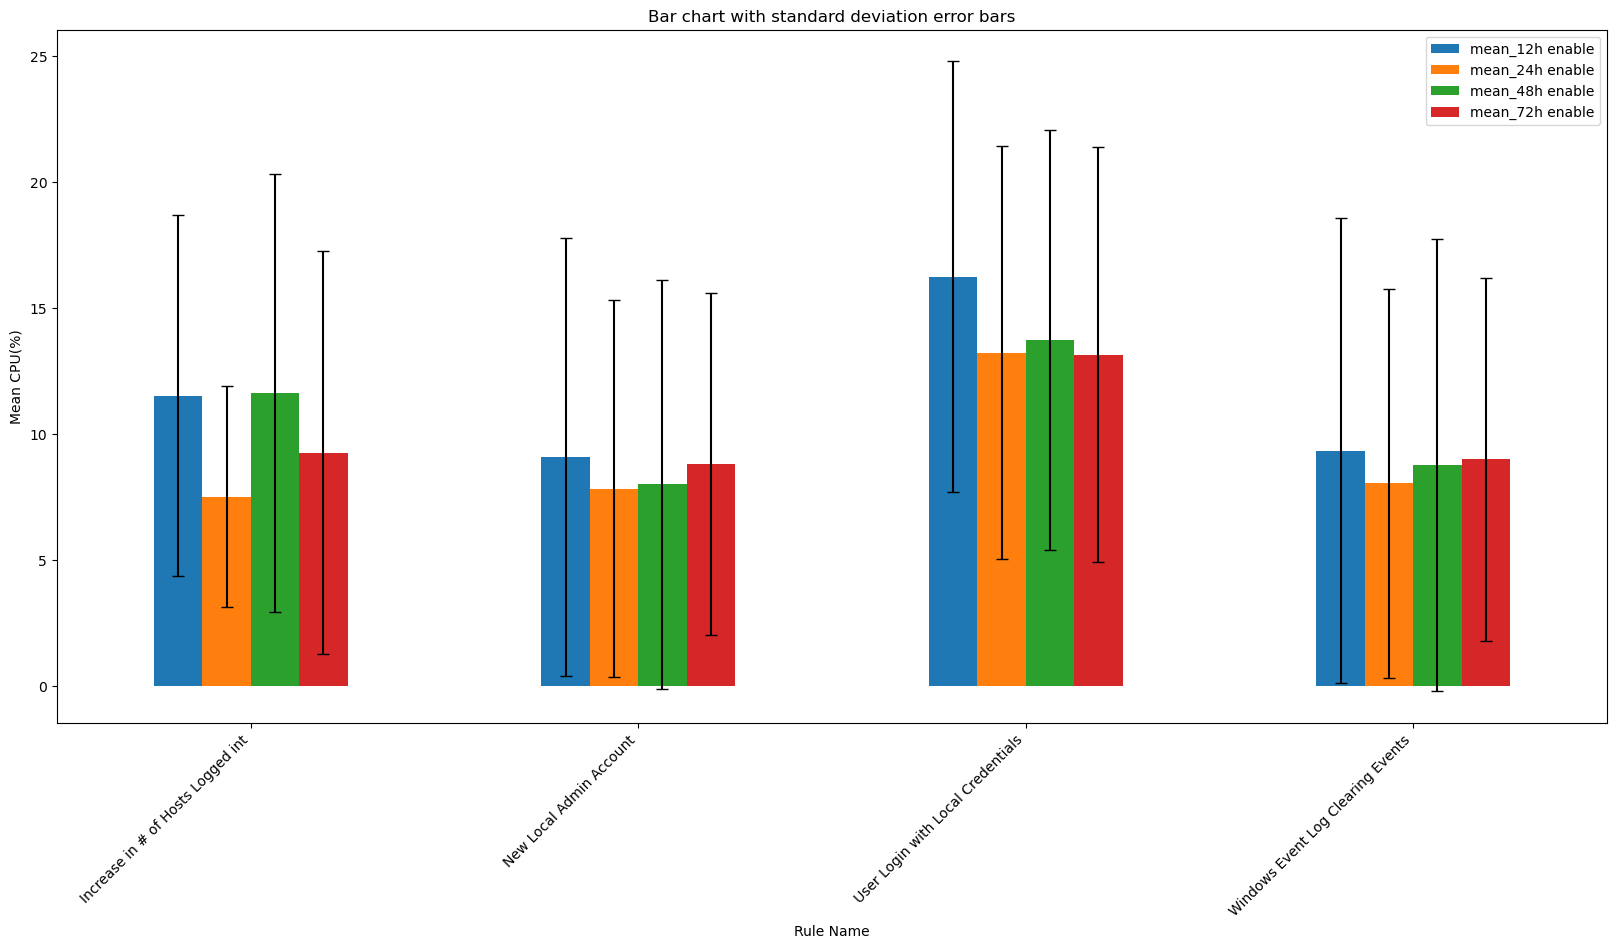

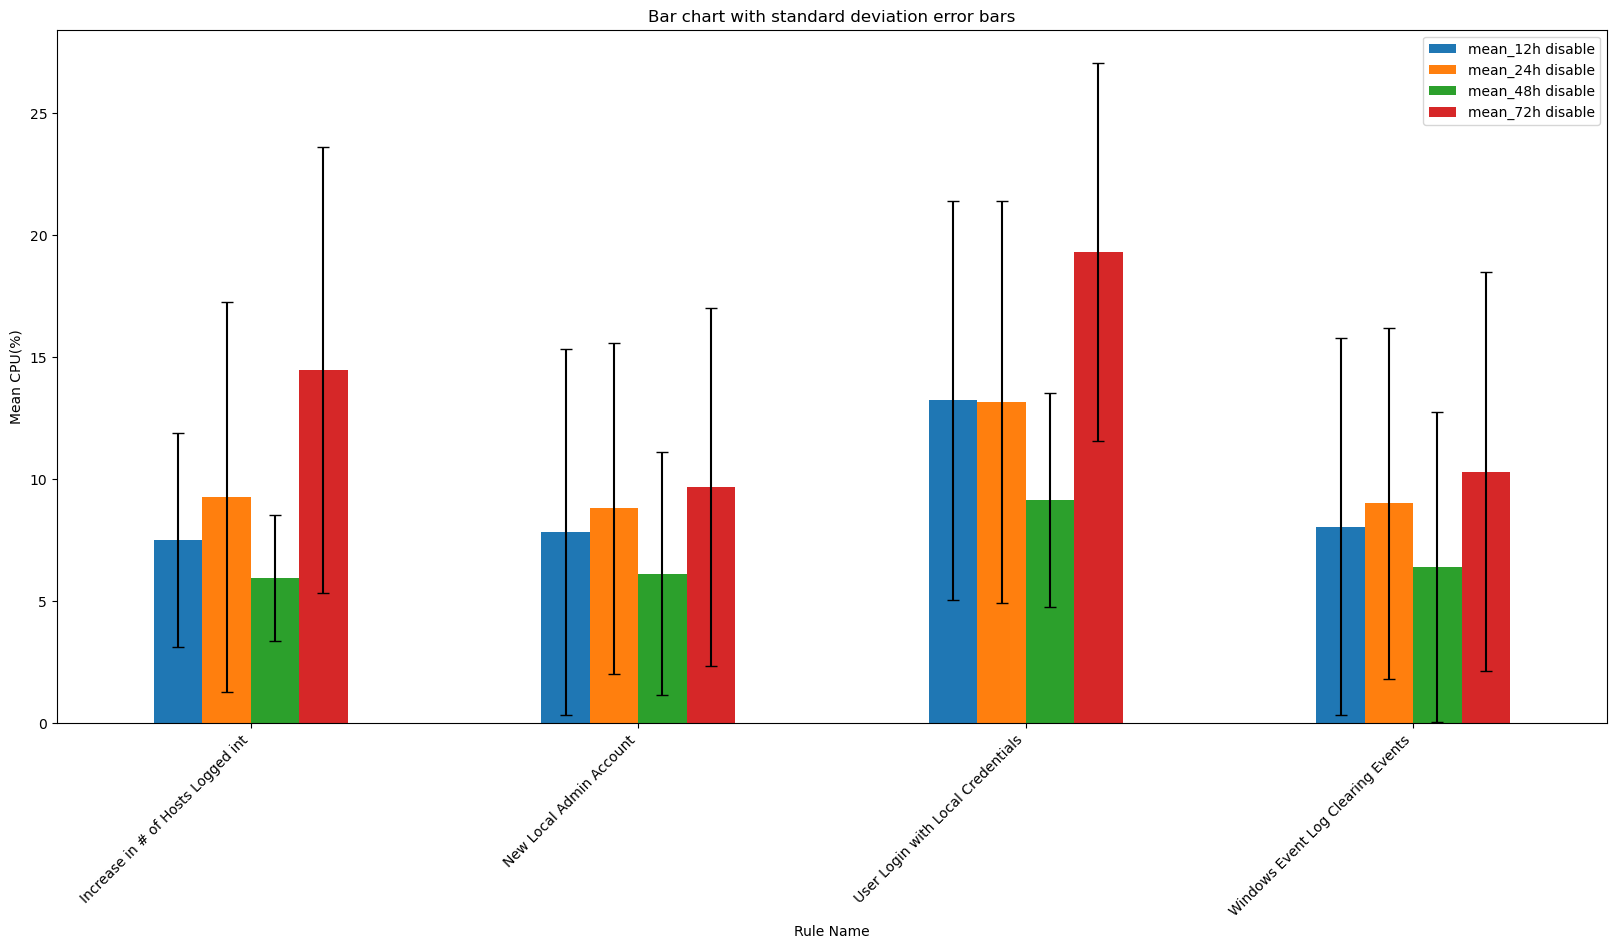

In [ ]:
# Set up the figure
# fig, ax = plt.subplots()
# df_to_plot = mean_std_df.reset_index().fillna(0)
# df_to_plot['std_15'] = df_to_plot['std_15'].astype(float)
# df_to_plot['std_30'] = df_to_plot['std_30'].astype(float)
# Plot the bars with error bars
for i in range(len(field_state)):  
    # ax = mean_std_df.reset_index()[["name"]+mean_cols].plot(x="name", kind="bar",capsize=4, rot=0, figsize=(20,9))
    ax = mean_df.iloc[:, len(times)*i:len(times)*(i+1)].reset_index().plot(x="duration", yerr=std_df.iloc[:, len(times)*i:len(times)*(i+1)].T.values, kind="bar", ,capsize=4, rot=0, figsize=(20,9))
    # ax.bar(mean_std_df.reset_index()['name'], mean_std_df.reset_index()[['mean_0','mean_1']], capsize=5)
    # plt.rcParams["figure.figsize"] = (20, 9)
    # Add axis labels and title
    ax.set_xlabel('Rule Name')
    ax.set_ylabel('Mean CPU(%)')
    ax.set_title('Bar chart with standard deviation error bars')
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.show()


In [ ]:
relevant_processes_pid_names.groupby('name').apply(lambda g: integrate.trapz(g['CPU(%)'], x=g['delta_time']))

name
Increase in # of Hosts Logged int    139.540020
New Local Admin Account               32.323367
User Login with Local Credentials    208.340708
Windows Event Log Clearing Events     40.679437
dtype: float64

In [ ]:
relevant_processes_pid_names.values

array([[Timestamp('2023-06-08 12:40:00.751596800+0000', tz='UTC'), 3666,
        'splunkd', ..., 'Windows Event Log Clearing Events', 3666, 0.0],
       [Timestamp('2023-06-08 12:40:00.934272256+0000', tz='UTC'), 3666,
        'splunkd', ..., 'Windows Event Log Clearing Events', 3666,
        0.182675456],
       [Timestamp('2023-06-08 12:40:01.099630080+0000', tz='UTC'), 3666,
        'splunkd', ..., 'Windows Event Log Clearing Events', 3666,
        0.34803328],
       ...,
       [Timestamp('2023-06-08 12:40:12.189276416+0000', tz='UTC'), 4090,
        'splunkd', ..., 'User Login with Local Credentials', 4090,
        11.437679616],
       [Timestamp('2023-06-08 12:40:12.252651264+0000', tz='UTC'), 4090,
        'splunkd', ..., 'User Login with Local Credentials', 4090,
        11.501054464],
       [Timestamp('2023-06-08 12:40:12.327145984+0000', tz='UTC'), 4090,
        'splunkd', ..., 'User Login with Local Credentials', 4090,
        11.575549184]], dtype=object)

In [ ]:
# concatenate the three data frames along the columns axis
merged_df = pd.concat([x for x in relevant_names_inegral_dict.values()], axis=1)
durations = [1]
num_of_different_durations = len([x for x in durations])
# select even and odd columns from the 'CPU(%)' columns
mean_std_df = pd.concat([merged_df.iloc[:, i::num_of_different_durations].agg(['mean', 'std'], axis=1).add_suffix('_'+str(durations[i])) for i in range(num_of_different_durations)], axis=1)
# mean_std_df.iloc[:, 0:2].columns = mean_std_df.iloc[:, 0:2].add_suffix('_odd').columns
# mean_std_df.iloc[:, 2:4].columns = mean_std_df.iloc[:, 2:4].add_suffix('_even').columns
# print the final dataframe
mean_std_df

,mean_1,std_1
name,,
Increase in # of Hosts Logged int,120.438259,21.381184
New Local Admin Account,34.747182,2.299977
User Login with Local Credentials,196.260893,39.319405
Windows Event Log Clearing Events,38.973061,5.370882


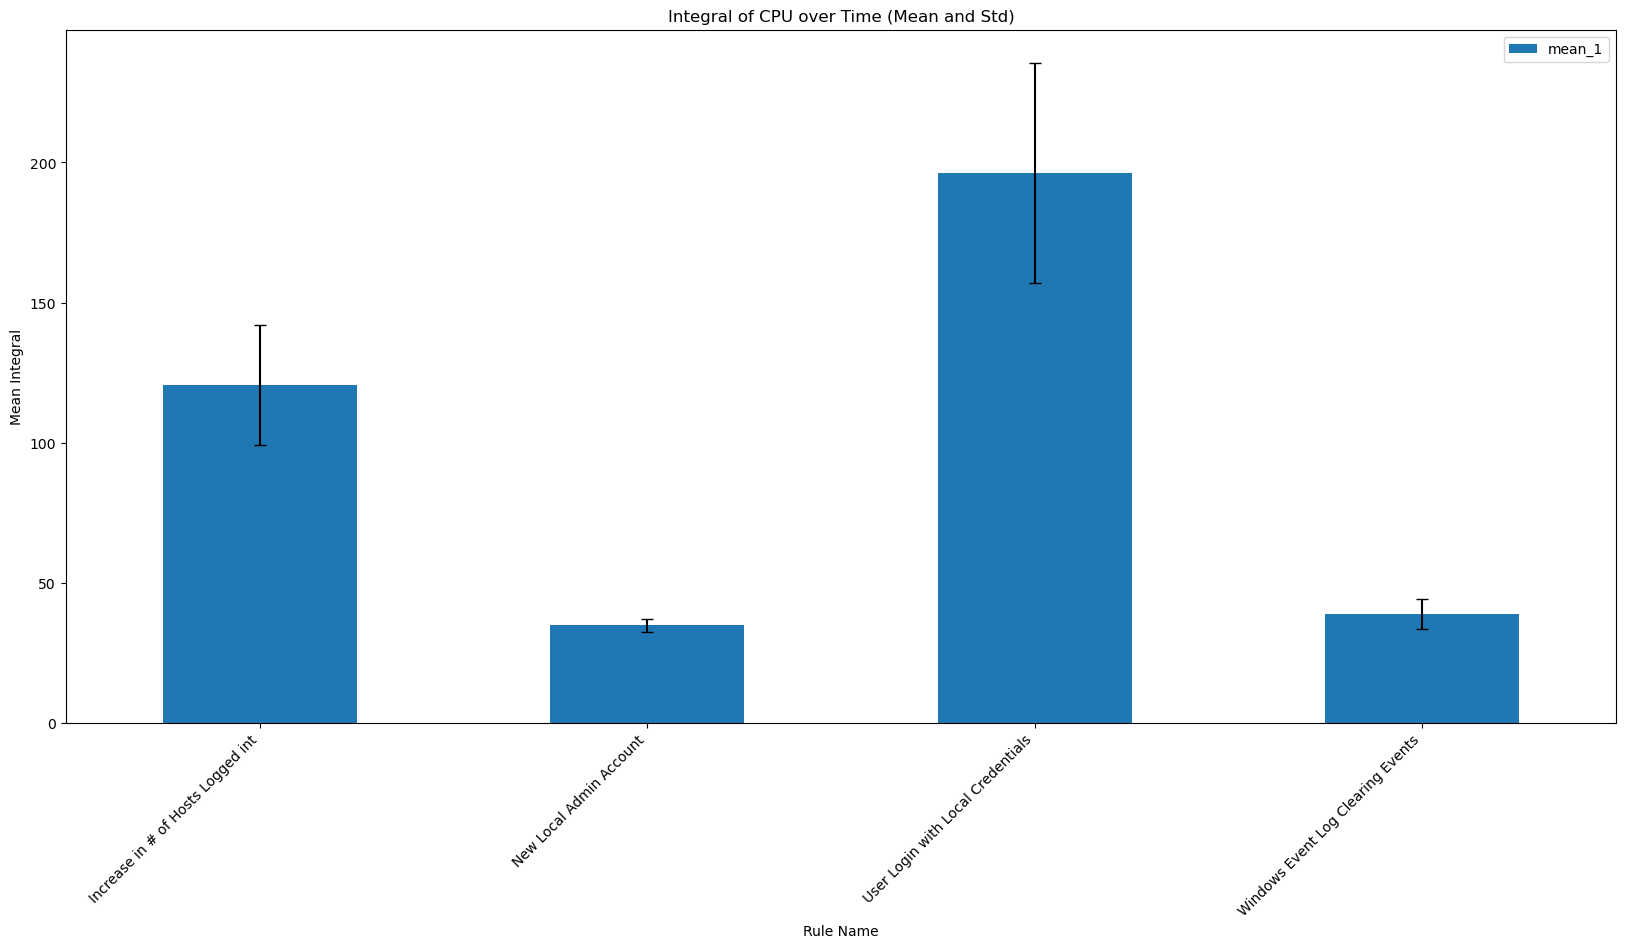

In [ ]:

# Set up the figure
# fig, ax = plt.subplots()
# df_to_plot = mean_std_df.reset_index().fillna(0)
# df_to_plot['std_15'] = df_to_plot['std_15'].astype(float)
# df_to_plot['std_30'] = df_to_plot['std_30'].astype(float)
# Plot the bars with error bars
mean_cols = [f"mean_{i}" for i in durations]
std_cols = [f"std_{i}" for i in durations]
ax = mean_std_df.reset_index()[["name"]+mean_cols].plot(x="name", yerr=mean_std_df[std_cols].T.values, kind="bar", rot=0, capsize=4, figsize=(20,9))
# ax.bar(mean_std_df.reset_index()['name'], mean_std_df.reset_index()[['mean_0','mean_1']], capsize=5)
# plt.rcParams["figure.figsize"] = (20, 9)
# Add axis labels and title
ax.set_xlabel('Rule Name')
ax.set_ylabel('Mean Integral')
ax.set_title('Integral of CPU over Time (Mean and Std)')
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [ ]:
df.integral[0]

{'Windows Event Log Clearing Events': 39.66785027467283,
 'New Local Admin Account': 35.41175174419554,
 'Increase in # of Hosts Logged int': 111.11761702284639,
 'User Login with Local Credentials': 172.57471908326698}

In [ ]:
sum_df = df
sum_df['sum_integral'] = df.integral.apply(lambda x: sum(x.values()))

In [ ]:
sum_df

,integral,duration,measurment_num,kind,logs_number,sum_integral
0,{'Windows Event Log Clearing Events': 39.66785...,enable_24,Measurement 22,lite,76,358.771938
1,"{'New Local Admin Account': 32.91334126636185,...",enable_48,Measurement 23,lite,40,447.093561
2,{'Windows Event Log Clearing Events': 43.79784...,disable_24,Measurement 24,heavy,97,332.294769
3,{'Windows Event Log Clearing Events': 40.90465...,disable_48,Measurement 25,heavy,4,418.795795


In [ ]:
df_group = sum_df.groupby(['duration','kind']).agg(['mean','std'])
df_group.columns = df_group.columns.to_flat_index()
df_group = df_group.reset_index()
df_group.columns = ['duration', 'kind','logs_number_mean','logs_number_std','sum_integral_mean','sum_integral_std']
df_group

/tmp/ipykernel_5789/3215586396.py:1: FutureWarning: ['integral', 'measurment_num'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_group = sum_df.groupby(['duration','kind']).agg(['mean','std'])


,duration,kind,logs_number_mean,logs_number_std,sum_integral_mean,sum_integral_std
0,disable_24,heavy,97.0,NaN,332.294769,NaN
1,disable_48,heavy,4.0,NaN,418.795795,NaN
2,enable_24,lite,76.0,NaN,358.771938,NaN
3,enable_48,lite,40.0,NaN,447.093561,NaN


In [ ]:
df_group['logs_number_std2'] = df_group['logs_number_mean']-df_group.logs_number_std/2
df_group['logs_number_std'] = df_group['logs_number_mean']+df_group.logs_number_std/2
df_group['sum_integral_std2'] = df_group['sum_integral_mean']-df_group.sum_integral_std/2
df_group['sum_integral_std'] = df_group['sum_integral_mean']+df_group.sum_integral_std/2
df_group

,duration,kind,logs_number_mean,logs_number_std,sum_integral_mean,sum_integral_std,logs_number_std2,sum_integral_std2
0,disable_24,heavy,97.0,NaN,332.294769,NaN,NaN,NaN
1,disable_48,heavy,4.0,NaN,418.795795,NaN,NaN,NaN
2,enable_24,lite,76.0,NaN,358.771938,NaN,NaN,NaN
3,enable_48,lite,40.0,NaN,447.093561,NaN,NaN,NaN


In [ ]:
line = alt.Chart(df_group).mark_line(point=True).encode(
            alt.Y("sum_integral_mean:Q",title='Sum CPU(%) Integral over Time'),
            alt.X(f"logs_number_mean:Q",title='Count of ingested logs quantity'),
        ).properties(
    width=1000,
    height=400,
    title=''
)
line

alt.Chart(...)

In [ ]:
x

NameError: name 'x' is not defined

In [ ]:
sum_df

,integral,duration,measurment_num,kind,logs_number,sum_integral
0,{'Windows Event Log Clearing Events': 39.66785...,enable_24,Measurement 22,lite,76,358.771938
1,"{'New Local Admin Account': 32.91334126636185,...",enable_48,Measurement 23,lite,40,447.093561
2,{'Windows Event Log Clearing Events': 43.79784...,disable_24,Measurement 24,heavy,97,332.294769
3,{'Windows Event Log Clearing Events': 40.90465...,disable_48,Measurement 25,heavy,4,418.795795


In [ ]:
x = sum_df.pivot_table(columns=['kind'], index=['logs_number','duration'], values='sum_integral').reset_index().groupby('duration').agg(['mean','std']).fillna(0)
x.columns = x.columns.to_flat_index()
x.columns = ['logs_number_mean','logs_number_std','heavy_sum_integral_mean','heavy_sum_integral_std','lite_sum_integral_mean','lite_sum_integral_std']

<Axes: xlabel='logs_number_mean'>

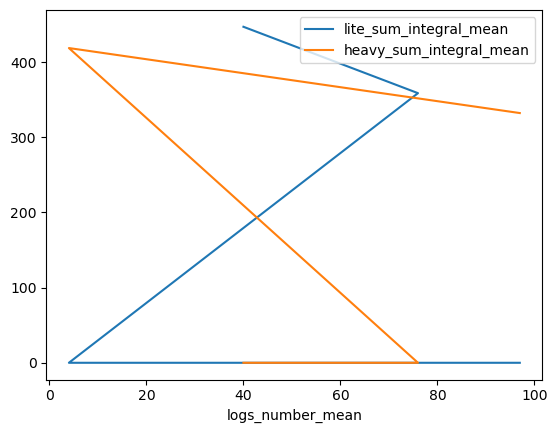

In [ ]:
x.plot(x='logs_number_mean',y=['lite_sum_integral_mean', 'heavy_sum_integral_mean'], yerr=x[['lite_sum_integral_std', 'heavy_sum_integral_std']], capsize=40)

In [ ]:
import altair as alt

# Melt the dataframe to long format
df_long = df_group.melt(id_vars=['duration', 'kind'])

# Define the base chart with faceting
base_chart = alt.Chart(df_long).mark_line(point=True).encode(
    alt.Y('value:Q', title='Mean and Standard Deviation'),
    alt.X('logs_number:Q'),
    alt.Color('kind:N'),
    facet=alt.Facet('stat:N', title=None, columns=2),
)

# Add error bars to each panel
error_bars_chart = base_chart.mark_errorbar().encode(
    y='value:Q',
    yError='stderr:Q',
)

# Calculate the standard error of the mean for each group
stderr = df_group.groupby(['duration', 'kind']).agg('std') / df_group.groupby(['duration', 'kind']).agg('count')

# Layer the error bars on top of the base chart
chart = (base_chart + error_bars_chart).transform_calculate(
    stderr=alt.datum['std'] / alt.datum['count']**0.5
).properties(
    title='Mean and Standard Deviation with Error Bars'
)

chart.show()


ValueError: Faceted charts cannot be layered. Instead, layer the charts before faceting.

In [ ]:
df.groupby(['duration','kind']).plot(x='logs_number', y='integral',kind='bar')

TypeError: no numeric data to plot

In [ ]:
import requests
from time import sleep

# Define the Splunk URL and login credentials
url = "https://132.72.81.185:8089/servicesNS/shoueii/splunkawssecuritymon/saved/searches/"
username = "shoueii"
password = ""

# Define the list of scheduled search names to enable/disable
searches_to_enable = ['aws_detect_cloudtrail_trail_deleted Clone1', 'aws_detect_cloudwatch_log_group_delete Clone1', 'aws_detect_cloudwatch_log_stream_delete Clone1', 'aws_detect_ec2_instances_run Clone1', 'aws_detect_ec2_vpc_flow_config_deleted Clone1', 'aws_detect_ecr_image_auth_token_get Clone1']
searches_to_disable = ['aws_detect_iam_user_deleted Clone', 'aws_detect_iam_user_created Clone', 'aws_detect_iam_new_policy_version_assignment Clone', 'aws_detect_iam_group_added_with_user_from_ec2 Clone', 'aws_detect_ecr_new_repo_image_create Clone', 'aws_detect_ec2_ssh_public_key_addition Clone']


for search_name in searches_to_enable:
    # Define the headers and payload for the request
    headers = {"Content-type": "application/json"}
    payload = {"disabled": 0}

    # Make the request to update the scheduled search
    response = requests.post(
        url + search_name + "/",
        headers=headers,
        auth=(username, password),
        data=payload,
        verify=False,
    )
    sleep(2)
    # Check the response status code
    if response.status_code == 200:
        print("Scheduled search updated successfully")
    else:
        print("Error updating scheduled search")
        print(response.content)
    

# Loop through the list of searches to disable and disable them
for search_name in searches_to_disable:
   # Define the headers and payload for the request
    headers = {"Content-type": "application/json"}
    payload = {"disabled": 1}

    # Make the request to update the scheduled search
    response = requests.post(
        url + search_name + "/",
        headers=headers,
        auth=(username, password),
        data=payload,
        verify=False,
    )

    # Check the response status code
    if response.status_code == 200:
        print("Scheduled search updated successfully")
    else:
        print("Error updating scheduled search")
        print(response.content)
    

/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully
Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [ ]:
import altair as alt
import pandas as pd
alt.data_transformers.enable('csv')

DataTransformerRegistry.enable('csv')

In [ ]:
import altair as alt
import pandas as pd
df = pd.read_csv('data_summary.csv')
df_dtsplunk = df[df['host']=='dt-splunk']
df = df[df['host']!='dt-splunk']
# create stacked bar chart with x axis tilted 45 degrees
chart = alt.Chart(df).mark_bar().encode(
    alt.X('host:N', title='Host name'),
    alt.Y('count:Q', title='Logs count'),
    alt.Color('sourcetype:N', title='Log sourcetype'),
).properties(
    width=1500,
    height=300,
    title='24 hours Logs count per host and sourcetype'
).configure_axis(
    labelFontSize=8,
    titleFontSize=20,
    labelAngle=45
)
chart

alt.Chart(...)

In [ ]:
df = pd.read_csv('eventtype_host.csv')
# create stacked bar chart with x axis tilted 45 degrees
chart = alt.Chart(df).mark_bar().encode(
    alt.X('host:N', title='Host name'),
    alt.Y('count:Q', title='Logs count'),
    alt.Color('eventtype:N', title='Log eventtype'),
).properties(
    width=1500,
    height=300,
    title='Last week Logs count per host and eventtype'
).configure_axis(
    labelFontSize=8,
    titleFontSize=20,
    labelAngle=45
)
chart

alt.Chart(...)

In [ ]:
df

,eventtype,host,count


In [ ]:
# find all the hosts that starts with 'dt'
df = pd.read_csv('eventtype_host.csv')
df = df[df['host'].str.startswith('DT')]
# create stacked bar chart with x axis tilted 45 degrees
chart = alt.Chart(df).mark_bar().encode(
    alt.X('host:N', title='Host name'),
    alt.Y('count:Q', title='Logs count'),
).properties(
    width=1500,
    height=300,
    title='One week Logs count per host and sourcetype'
).configure_axis(
    labelFontSize=8,
    titleFontSize=20,
    labelAngle=45
)
chart

alt.Chart(...)

In [ ]:
df = pd.read_csv('eventtype_hour_30.csv')
df.hour = pd.to_datetime(df.hour)
# create stacked bar chart with x axis tilted 45 degrees
chart = alt.Chart(df).mark_bar().encode(
    alt.X('hours(hour):T', title='Hour'),
    alt.Y('count:Q', title='Logs count'),
    alt.Color('eventtype:N', title='Log event type',sort=alt.SortField(field='count', order='descending')),
)
# add rule lines for sign the days
rule = alt.Chart(df).mark_rule(color='red', strokeDash=[5, 5]).encode(
    x='day:T'
).transform_timeunit(
    day='yearmonthdate(hour)'
)
(chart).properties(
    width=1500,
    height=300,
    title='Last month Logs count per event type'
).configure_axis(
    labelFontSize=15,
    titleFontSize=20,
    labelAngle=45
)


alt.Chart(...)

In [ ]:
df = pd.read_csv('eventtype_hour_30.csv')
df.hour = pd.to_datetime(df.hour)
# create stacked bar chart with x axis tilted 45 degrees
chart = alt.Chart(df).mark_bar().encode(
    alt.X('day(hour):T', title='Day'),
    alt.Y('mean(count):Q', title='Logs count'),
    alt.Color('eventtype:N', title='Log event type',sort=alt.SortField(field='count', order='descending')),
)
# add rule lines for sign the days
rule = alt.Chart(df).mark_rule(color='red', strokeDash=[5, 5]).encode(
    x='day:T'
).transform_timeunit(
    day='yearmonthdate(hour)'
)
(chart).properties(
    width=1500,
    height=300,
    title='Last month Logs count per event type'
).configure_axis(
    labelFontSize=15,
    titleFontSize=20,
    labelAngle=45
)


alt.Chart(...)

In [ ]:
df

,eventtype,hour,count
0,endpoint_services_processes,2023-04-23 00:00:00,430
1,endpoint_services_processes,2023-04-23 01:00:00,626
2,endpoint_services_processes,2023-04-23 02:00:00,533
3,endpoint_services_processes,2023-04-23 03:00:00,839
4,endpoint_services_processes,2023-04-23 04:00:00,739
...,...,...,...
16402,winsystem,2023-05-23 19:00:00,2200
16403,winsystem,2023-05-23 20:00:00,1379
16404,winsystem,2023-05-23 21:00:00,102
16405,winsystem,2023-05-23 22:00:00,200


In [ ]:
chart = alt.Chart(df).mark_line().encode(
    alt.X('yearmonthdate(hour):T', title='Hour'),
    alt.Y('mean(count):Q', title='Logs count'),
    alt.Color('eventtype:N', title='Log event type'),
)
# add rule lines for sign the days
rule = alt.Chart(df).mark_rule(color='red', strokeDash=[3, 3]).encode(
    x='day:T'
).transform_timeunit(
    day='yearmonthdate(hour)'
)
(chart+rule).properties(
    width=1500,
    height=300,
    title='Last month Logs count per event type'
).configure_axis(
    labelFontSize=15,
    titleFontSize=20,
    labelAngle=45
)

alt.LayerChart(...)

In [ ]:
df[df.hour.dt.hour==7].groupby('eventtype').sum().sort_values('count', ascending=False)

/tmp/ipykernel_30871/2909946745.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df.hour.dt.hour==7].groupby('eventtype').sum().sort_values('count', ascending=False)


,count
eventtype,
endpoint_services_processes,700636
windows_event_signature,700636
wineventlog_windows,481102
winsec,314056
wineventlog_security,314056
ms-sysmon-regmod,219265
windows_account_management,127190
wineventlog_system,100351
winsystem,100351


In [ ]:
# make pie chart from dt splunk
pie_chart = alt.Chart(df[df.hour.dt.hour==7]).mark_arc().encode(
    alt.Theta('count:Q', title='Logs count'),
    alt.Color('eventtype:N', title='Log eventtype',sort=alt.SortField(field='count', order='descending')),
).properties(
    width=800,
    height=800,
    title='Last month 7 am count per sourcetype'
)
pie_chart

alt.Chart(...)

In [ ]:
# make pie chart from dt splunk
df = pd.read_csv('eventtype_source.csv')
chart = alt.Chart(df).mark_bar().encode(
    alt.Color('eventtype:N', title='Log eventtype'),
    alt.Y('count:Q', title='Logs count'),
    alt.X('source:N', title='source'),
).properties(
    width=1000,
    height=800,
    title='Last week DT-Splunk host Logs count per eventtype'
).configure_axis(
    labelFontSize=15,
    titleFontSize=20,
    labelAngle=45
).configure_legend(
    labelFontSize=15
)
chart

alt.Chart(...)

In [ ]:
# make pie chart from dt splunk
pie_chart = alt.Chart(df_dtsplunk).mark_arc().encode(
    alt.Theta('count:Q', title='Logs count'),
    alt.Color('sourcetype:N', title='Log sourcetype',sort=alt.SortField(field='count', order='descending')),
).properties(
    width=600,
    height=500,
    title='24 hours DT-Splunk host Logs count per sourcetype'
)
pie_chart

alt.Chart(...)

In [ ]:
hosts = pd.read_csv('last_2_weeks_hosts.csv')

In [ ]:
hosts.host = hosts.host.str.lower()
hosts.sort_values('host', ascending=True)
# cancel show all the df config
alt.data_transformers.disable_max_rows()




DataTransformerRegistry.enable('csv')

In [ ]:
df.user.unique()

array(['CYB301-4$', 'Guest', 'LOCAL SERVICE', 'NETWORK SERVICE',
       'NOT_TRANSLATED', 'SYSTEM', 'tigranb', 'yevsikov', 'Administrator',
       'CYB301-ATAM-20$', 'D77C167F-2E40-48BC-B64A-E12FAD864D2F',
       'DefaultAccount', 'WDAGUtilityAccount', 'muralidh',
       'CYB301-ATAM-21$', '-', 'DT-117-01$', 'DWM-1', 'UMFD-0', 'UMFD-1',
       'idodah', 'DT-AWS-NEO4J-2$', 'DT-CTI-DRL$', 'DT-IT$', 'R18-ILYA$',
       'adinr', 'bsrelan', 'nicolayg', 'DT-JAIDIP$', 'DT-O2$', 'salitsl',
       'DT-O5$', 'vitals', 'yehudith', 'yehudith@bgu-users', 'DT-O7$',
       'DWM-2', 'UMFD-2', 'admin', 'yovell', 'DT-PRINT$', 'Eitan',
       'dvaleria', 'freidiya', 'ilialey', 'ANONYMOUS LOGON', 'DT-WDS$',
       'peledf@bgu.ac.il', 'DTS12-VM1$', 'SQLSERVERAGENT', 'DTS12-VM2$',
       'MSSQLServerOLAPService', 'ISE-MGMT$', 'LB-003-1$', 'LB-003-10$',
       'LB-003-11$', 'LB-003-12$', 'LB-003-13$', 'LB-003-14$',
       'LB-003-15$', 'LB-003-16$', 'LB-003-17$', 'LB-003-18$',
       'LB-003-19$', 'LB-003-2$

In [ ]:
df = pd.read_csv('host_host_type_user_24h.csv')
df = df[df.host_type=='dt']
chart = alt.Chart(df).mark_bar().encode(
    alt.Color('host:N', title='host'),
    alt.Y('count:Q', title='Logs count'),
    alt.X('user:N', title='user_name',sort=alt.SortField(field='host_type', order='descending')),
).properties(
    width=2500,
    height=600,
    title='hosts'
).configure_axis(
    labelFontSize=15,
    titleFontSize=20,
    labelAngle=45
).configure_legend(
    labelFontSize=15
)
chart

alt.Chart(...)

In [ ]:
df = pd.read_csv('source_host_type_user_24h.csv')
df = df[df.host_type=='dt']
chart = alt.Chart(df).mark_bar().encode(
    alt.Color('source:N', title='host'),
    alt.Y('count:Q', title='Logs count'),
    alt.X('user:N', title='user_name',sort=alt.SortField(field='host_type', order='descending')),
).properties(
    width=2500,
    height=600,
    title='hosts'
).configure_axis(
    labelFontSize=15,
    titleFontSize=20,
    labelAngle=45
).configure_legend(
    labelFontSize=15
)
chart

alt.Chart(...)

In [ ]:
df = pd.read_csv('host_type_host_24h.csv')
chart = alt.Chart(df).mark_bar().encode(
    alt.Color('host_type:N', title='host_type'),
    alt.Y('count:Q', title='Logs count'),
    alt.X('host:N', title='host',sort=alt.SortField(field='host_type', order='descending')),
).properties(
    width=2500,
    height=600,
    title='hosts'
).configure_axis(
    labelFontSize=15,
    titleFontSize=20,
    labelAngle=45
).configure_legend(
    labelFontSize=15
)
chart

In [ ]:
df = pd.read_csv('host_type_source_24h.csv')
chart = alt.Chart(df).mark_bar().encode(
    alt.X('host_type:N', title='host_type'),
    alt.Y('count:Q', title='Logs count'),
    alt.Color('source:N', title='source'),
).properties(
    width=800,
    height=600,
    title='hosts sources'
).configure_axis(
    labelFontSize=15,
    titleFontSize=20,
    labelAngle=45
).configure_legend(
    labelFontSize=15,
    labelLimit=10000
)
chart

alt.Chart(...)